# <center> ДЗ 26. Прогноз просрочки кредита заемщиком с использованием нейросетей</center>

### Татур А.А.
### V.0.1
### 09.02.2022
### Цель: Выполнить задачу бинарной классификации с использованием нейронных сетей.

In [429]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.metrics import AUC

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

MM  = MinMaxScaler(feature_range=(0,1))

In [430]:
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [431]:
'''
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None

if tpu:
    policyConfig = 'mixed_bfloat16'
else: 
    policyConfig = 'mixed_float16'
policy = tf.keras.mixed_precision.Policy(policyConfig)
tf.keras.mixed_precision.set_global_policy(policy)
'''

"\ntry:\n    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection\nexcept ValueError:\n    tpu = None\n\nif tpu:\n    policyConfig = 'mixed_bfloat16'\nelse: \n    policyConfig = 'mixed_float16'\npolicy = tf.keras.mixed_precision.Policy(policyConfig)\ntf.keras.mixed_precision.set_global_policy(policy)\n"

In [432]:
#
#tf.tpu.XLAOptions(
#    use_spmd_for_xla_partitioning=True, enable_xla_dynamic_padder=True
#)

### Описание набора данных

Данные представляют собой исторические данные по 251503 заемщикам (https://www.kaggle.com/c/GiveMeSomeCredit/data ). Задача является бинарной классификацией. Цель - предсказать будет ли тот или иной заемщик испытывать финансовые трудности в ближайшие 2 года, т.е. будет ли просрочка по займу. Выборка разделена на тренировочную и тестовую ( 150000 в тренировочной части, 101503 в тестовой).

Данная решаемая задача будет ценна как кредиторам, так и заемщикам для оценки способности вернуть долг вовремя.

### Описание признаков

* 1 - __SeriousDlqin2yrs__ - будет ли просрочка более 90 дней в ближайшие 2 года (целевая метка) (Да/Нет)
* 2 - __RevolvingUtilizationOfUnsecuredLines__ - общий баланс по кредитным картам и кредитным линиям, за исключением задолженностей по недвижимости задолженности по взносам, деленные на сумму кредитных лимитов (проценты)
* 3 - __age__ - Возраст заемщика (в годах)
* 4 - __NumberOfTime30-59DaysPastDueNotWorse__ - количество просрочек в 30-59 дней (Целое)
* 5 - __DebtRatio__ - коэффициент задолженности, т.е. сумма ежемесячных платежей по долгам, алиментов и расходов на проживание, деленная на месячный доналоговый доход (проценты)
* 6 - __Monthly Income__ - месячный доход (число с плавающей точкой)
* 7 - __NumberOfOpenCreditLinesAndLoans__ - количество открытых кредитов и кредитных линий (Целое)
* 8 - __NumberOfTimes90DaysLate__ - количество просрочек более 90 дней (Целое)
* 9 - __NumberRealEstateLoansOrLines__ - количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии домашнего капитала (Целое)
* 10 - __NumberOfTime60-89DaysPastDueNotWorse__ - количество просрочек в 60-89 дней за последние 2 года (Целое)
* 11 - __NumberOfDependents__ - количество иждивенцев в семье (исключая самих заемщиков) (Целое)

In [433]:
def make_submission(predictions, fname):
    out = pd.DataFrame(data=predictions, columns=['Probability'])
    out.index += 1
    out.to_csv(fname, index_label='id')

In [434]:
df = pd.read_csv('cs-training.csv', index_col=0)
#df.dropna(axis=0, inplace=True)

In [435]:
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

Проверьте наличие категориальных признаков, а также соответствие содержимого данных их типам

In [436]:
list(set(df._get_numeric_data().columns)-set(df.columns))

[]

### I. Эксплоративный анализ. Проверяем значения по отдельным колонкам

##### 01. Проверим значения по колонке 'age'

In [437]:
pd.set_option('display.max_rows', None)
pd.DataFrame(df.age.value_counts()).sort_index()

,age
0,1
21,183
22,434
23,641
24,816
25,953
26,1193
27,1338
28,1560
29,1702


##### Удалим ту строку, где возраст равен '0', т.к. этот случай единичен.

In [438]:
pd.set_option('display.max_rows', 10)
df.loc[df.age==0].index[0] # вычисляем индекс строки, в которой возраст равен '0'
df.drop(df.loc[df.age==0].index[0], axis=0, inplace=True)

##### 02. Проверим значения по колонке 'NumberOfTime30-59DaysPastDueNotWorse'

In [439]:
pd.set_option('display.max_rows', None)
pd.DataFrame(df['NumberOfTime30-59DaysPastDueNotWorse'].value_counts()).sort_index()

,NumberOfTime30-59DaysPastDueNotWorse
0,126018
1,16032
2,4598
3,1754
4,747
5,342
6,140
7,54
8,25
9,12


##### Вывод: Поскольку значения '96' и "98' в колонке 'NumberOfTime30-59DaysPastDueNotWorse' очень сильно отличаются от других. Можно предположить, что на самом деле это значения '06' и '08'. Поэтом поменяем их значения на '6' и '8' соответственно

In [440]:
df.loc[df['NumberOfTime30-59DaysPastDueNotWorse']==96, 'NumberOfTime30-59DaysPastDueNotWorse']=6
df.loc[df['NumberOfTime30-59DaysPastDueNotWorse']==98, 'NumberOfTime30-59DaysPastDueNotWorse']=8

##### 03. Проанализируем колонки 'DebtRatio' и 'MonthlyIncome' вместе (т.к. два параметра тесно связаны). Поскольку в колонке 'MonthlyIncome' есть NaN Значения, то заменим их на -1 чтобы можно было визуализировать все на графиках.

In [441]:
df.MonthlyIncome.fillna(-1, inplace=True)

<AxesSubplot: xlabel='MonthlyIncome', ylabel='DebtRatio'>

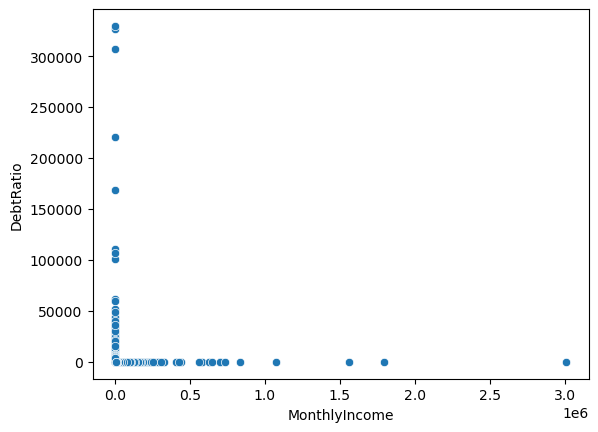

In [442]:
sns.scatterplot(x='MonthlyIncome',y='DebtRatio', data=df)

##### Построим график снова с ограничением по значению месячного дохода до 5

<AxesSubplot: xlabel='MonthlyIncome', ylabel='DebtRatio'>

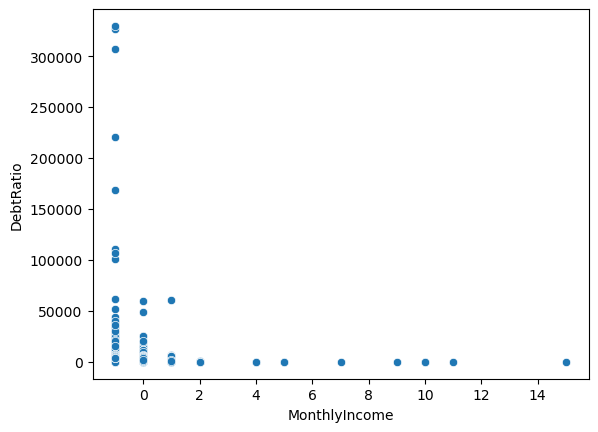

In [443]:
sns.scatterplot(x='MonthlyIncome',y='DebtRatio', data=df.loc[df.MonthlyIncome<20])

##### Посчитаем как распределяется DebtRatio в зависимости от дохода

In [444]:
pd.qcut(df.loc[df['MonthlyIncome']==-1, 'DebtRatio'],90, duplicates="drop").value_counts()

(-0.001, 1.0]           1827
(2.0, 5.0]               450
(7.0, 11.0]              417
(37.0, 44.0]             358
(22.0, 27.0]             353
(51.0, 60.0]             348
(31.0, 37.0]             347
(1761.0, 1816.0]         341
(297.0, 344.0]           338
(1006.0, 1056.0]         338
(81.0, 96.0]             337
(1353.0, 1398.0]         337
(598.333, 653.0]         336
(96.0, 113.0]            335
(1865.667, 1926.0]       335
(2038.667, 2105.0]       335
(168.0, 207.0]           335
(1446.0, 1493.0]         334
(2415.0, 2486.0]         334
(2817.333, 2910.0]       334
(1708.0, 1761.0]         334
(3010.0, 3114.0]         333
(1547.0, 1599.0]         332
(432.0, 473.0]           332
(653.0, 701.0]           332
(804.0, 858.0]           332
(1159.0, 1207.0]         332
(388.0, 432.0]           332
(2163.0, 2225.0]         332
(4166.667, 4416.0]       332
(1599.0, 1651.0]         331
(2352.0, 2415.0]         331
(2562.333, 2642.0]       331
(3463.333, 3604.0]       331
(5094.333, 558

##### Вывод: как видно из представленного графика и возможных значений DebtRatio - наиболее вероятно при N/A Значений имеется ввиду нулевой доход, т.к. DebtRatio значительно больше нуля в большинстве случаев, а такого не может быть, человеку не могут выдать кредитов больше, чем он может погасить. Значит наиболее оправданным подходом является: для тех случаев, где DebtRatio <1 заполнить N/A медианным значением по колонке, в остальных случаях присвоить значение 0.

In [445]:
df.loc[(df.MonthlyIncome==-1)&(df.DebtRatio<1), 'MonthlyIncome']=df.MonthlyIncome.median()
df.loc[df['MonthlyIncome']==-1, 'MonthlyIncome']=0

##### 04. Проверим значения по колонке 'NumberOfTimes90DaysLate'

In [446]:
pd.set_option('display.max_rows', None)
pd.DataFrame(df.NumberOfTimes90DaysLate.value_counts()).sort_index()

,NumberOfTimes90DaysLate
0,141661
1,5243
2,1555
3,667
4,291
5,131
6,80
7,38
8,21
9,19


##### Как и для 'NumberOfTime30-59DaysPastDueNotWorse' заменим и тут значения 96 и 98 на 6 и 8

In [447]:
df.loc[df['NumberOfTimes90DaysLate']==96, 'NumberOfTimes90DaysLate']=6
df.loc[df['NumberOfTimes90DaysLate']==98, 'NumberOfTimes90DaysLate']=8

##### 05 Для NumberOfTime60-89DaysPastDueNotWorse тоже самое. Замени 96 и 98 на 6 и 8

In [448]:
df.loc[df['NumberOfTime60-89DaysPastDueNotWorse']==96, 'NumberOfTime60-89DaysPastDueNotWorse']=6
df.loc[df['NumberOfTime60-89DaysPastDueNotWorse']==98, 'NumberOfTime60-89DaysPastDueNotWorse']=8

##### 06. Проверим значения NumberOfDependents

In [449]:
pd.set_option('display.max_rows', None)
pd.DataFrame(df['NumberOfDependents'].value_counts())

,NumberOfDependents
0.0,86902
1.0,26316
2.0,19521
3.0,9483
4.0,2862
5.0,746
6.0,158
7.0,51
8.0,24
10.0,5


In [450]:
pd.set_option('display.max_rows', 10)

##### Вывод: Заполним пропуски медианным значением

In [451]:
df.NumberOfDependents.fillna(df.NumberOfDependents.median(), inplace=True)

##### 07. Поищем дубликаты в сете

In [452]:
sum(df.duplicated())

768

##### Удалим дубликаты

In [453]:
df.drop(df.loc[df.duplicated()].index, axis=0, inplace=True)

### II. Визуализируем сет.

##### 01. Используя  seaborn.pairplot (sns) визуализируйте данные (Учитывая ресурсозатратность данного графика возьмем из исходного набора лишь часть случаев, при этом сохранив изначальную пропорцию возвратов и невозвратов)

In [454]:
df_short = pd.concat([df.loc[df.SeriousDlqin2yrs==0][:100], #100 первых случаев с возвратом кредита
                      df.loc[df.SeriousDlqin2yrs==1][:10]], #10 первых с невозвратом
                     axis=0)

In [455]:
#sns.pairplot(df_short,
#           hue="SeriousDlqin2yrs", 
#            diag_kind="hist",
#            corner=True)

##### 02. Используя sns.heatmap постройте корреляционную матрицу

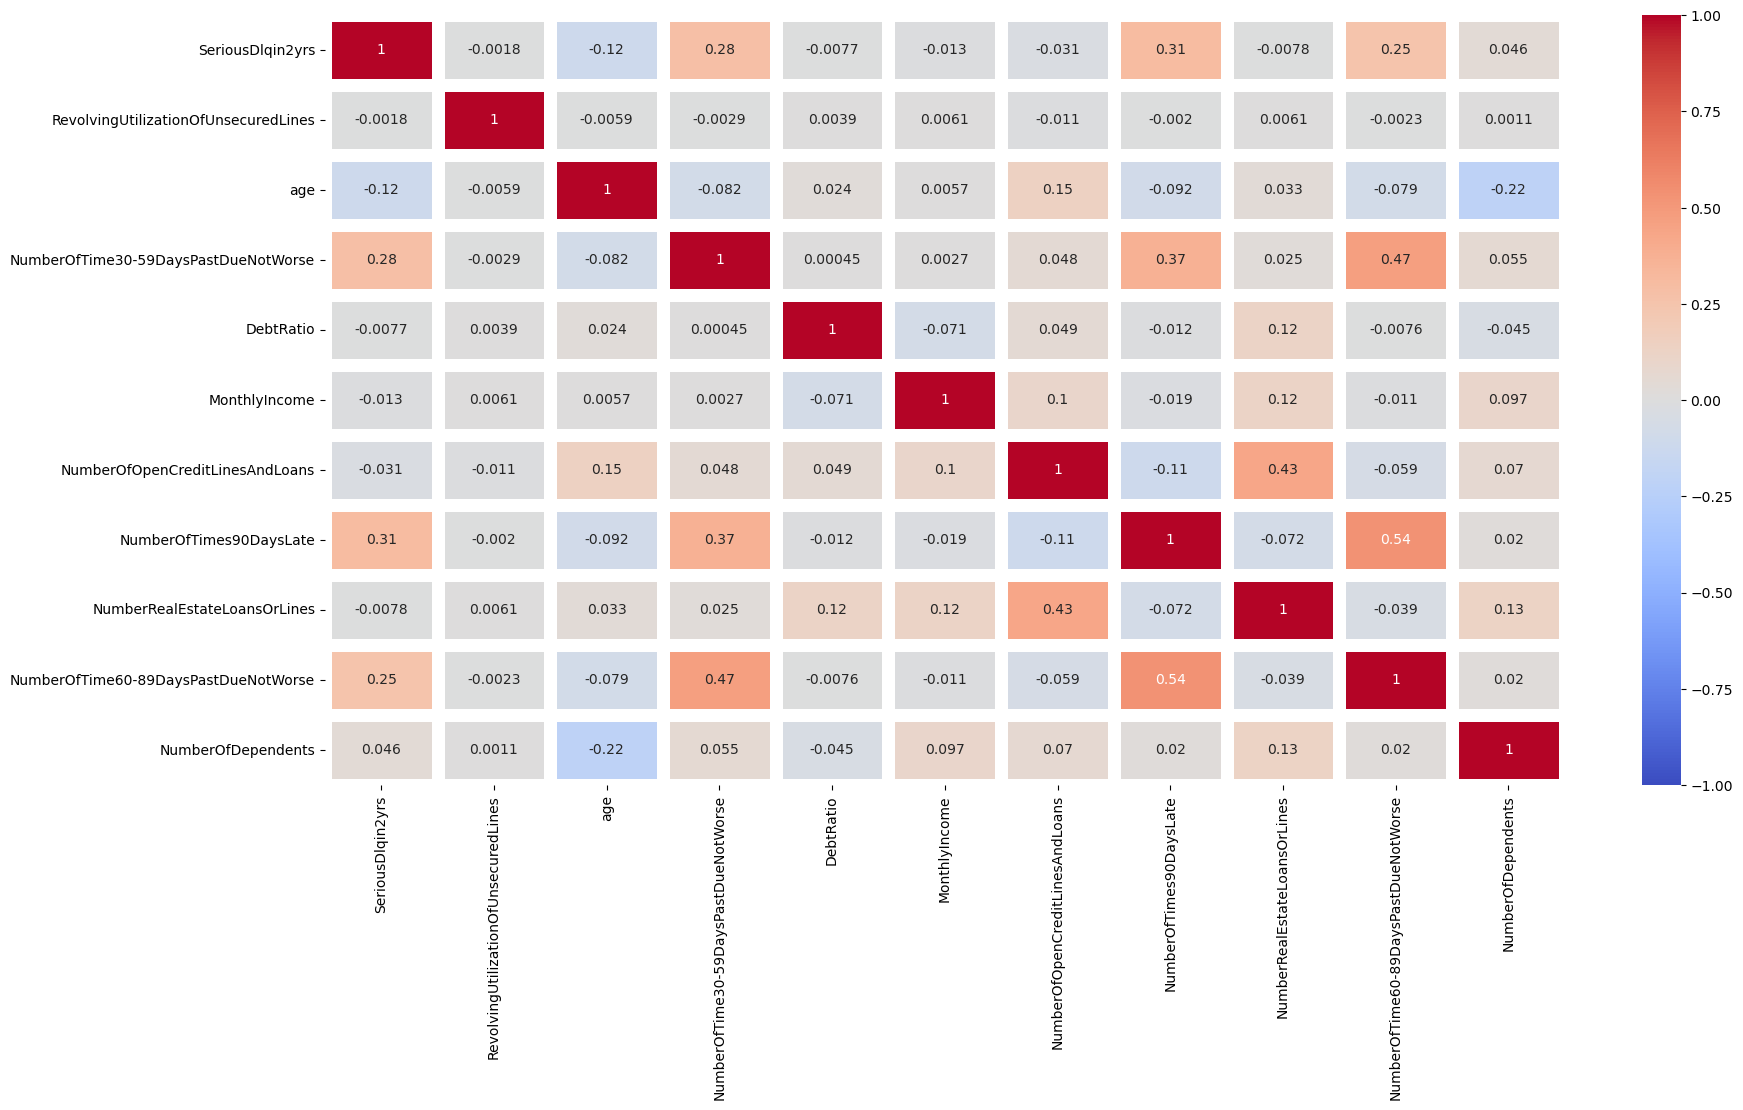

In [456]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),
            annot=True, 
            vmin=-1, vmax=1, 
            center= 0, 
            cmap= 'coolwarm', 
            linewidths=9, 
            linecolor='white', 
            cbar_kws= {'orientation': 'vertical'});

Какие существуют зависимости в данных?
Опишите зависимости каждого из признаков!

Корелляцию можно видеть среди двух групп признаков:

* 1. __NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse, NumberOfTime30-59DaysPastDueNotWorse__
* 2. __NumberOfOpenCreditLinesAndLoans и NumberRealEstateLoansOrLines__

Что может говорить о том, что:
1) Клиент, который просрочил выплату на 30-59 дней, просрочит ее и на 60-89 и на 90 дней.

2) Кредит на квартиру уже входит в признак "Число открытых кредитов"


__Однако, их удаление ни к чему хорошему не привело. Метрики обучения падают на 6-7 процентов. Поэтому колонки эти все оставил__

##### 03. Визуализация связи дохода и невозвратов.

<AxesSubplot: xlabel='MonthlyIncome', ylabel='count'>

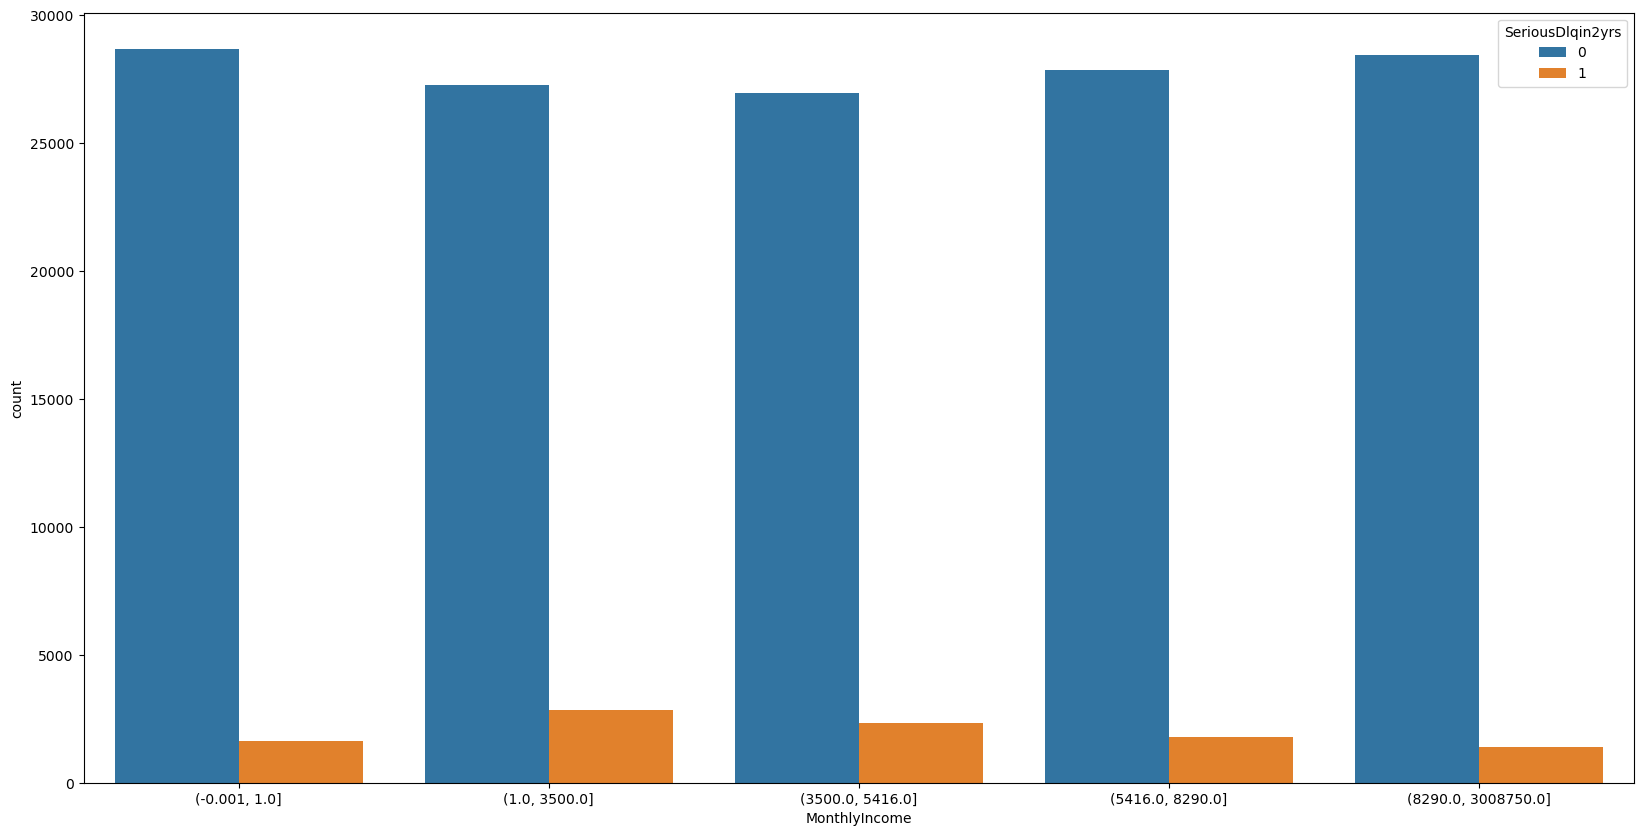

In [457]:
income_binned = income_binned = pd.qcut (df.MonthlyIncome, 5, duplicates='drop')

plt.figure(figsize=(20,10))
sns.countplot (x=income_binned, hue=df.SeriousDlqin2yrs)

#### Вывод: Данный график отражает интересную связь. Те люди, которые имеют в настоящий момент фактически нулевой доход (вероятно в результате потери работы) имеют меньшее количество невозвратов, нежели те, кто хронически мало зарабатывает. Далее количество невозвратов падает по мере роста доходов

### III. __Создание новых признаков__

1. Выберите признаки подлежащие бинаризации.
2. Осуществите бинаризацию.
3. Как влияет количество интервалов бинаризации на качество модели? 

Для создания новых признаков рекомендую ответить на следующие вопросы:
Как влияют количество иждевенцев у заемщика на просрочку выплат?
Какой тип кредитов чаще всего берет заемщик?

#### 01. Оценим количество кредитов по количеству лиц на иждивении

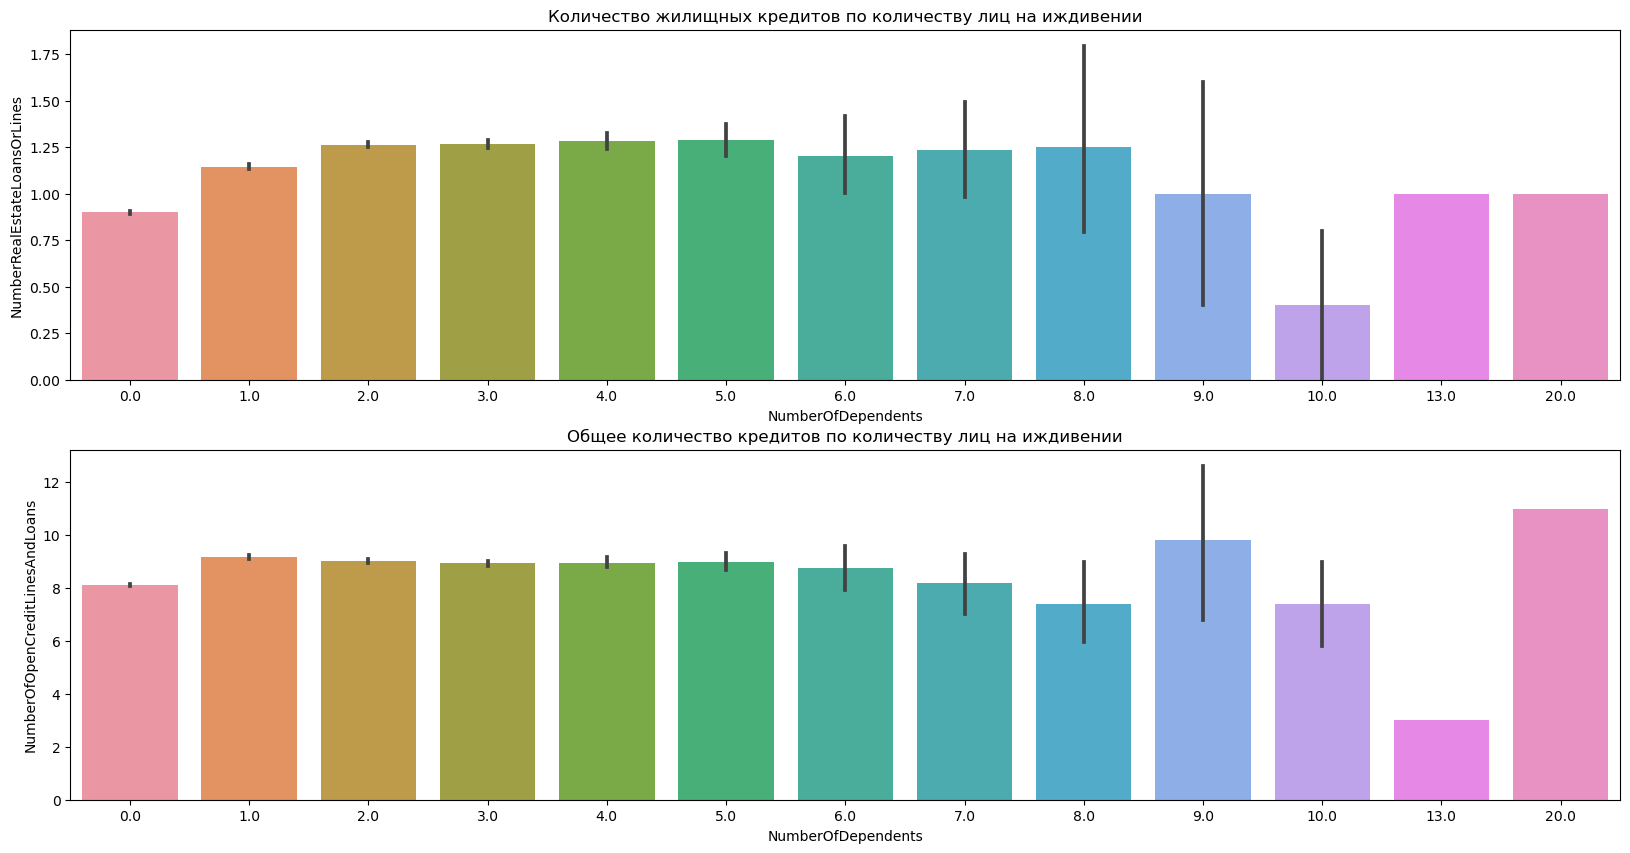

In [458]:
plt.figure(figsize=(20,10))


plt.subplot (2,1,1)
sns.barplot(data=df, x=df.NumberOfDependents, y='NumberRealEstateLoansOrLines');
plt.title ('Количество жилищных кредитов по количеству лиц на иждивении');

plt.subplot (2,1,2)
sns.barplot(data=df, x=df.NumberOfDependents, y='NumberOfOpenCreditLinesAndLoans');
plt.title ('Общее количество кредитов по количеству лиц на иждивении');

#### Вывод: у лиц без или с 9 иждивенцами и более меньше всего кредитов на жилье. А у лиц с 9 и 20 иждивенцами больше всего других кредитов.

#### 02. Оценим количество просрочек в зависимости от числа лиц на иждивении после разбития на группы

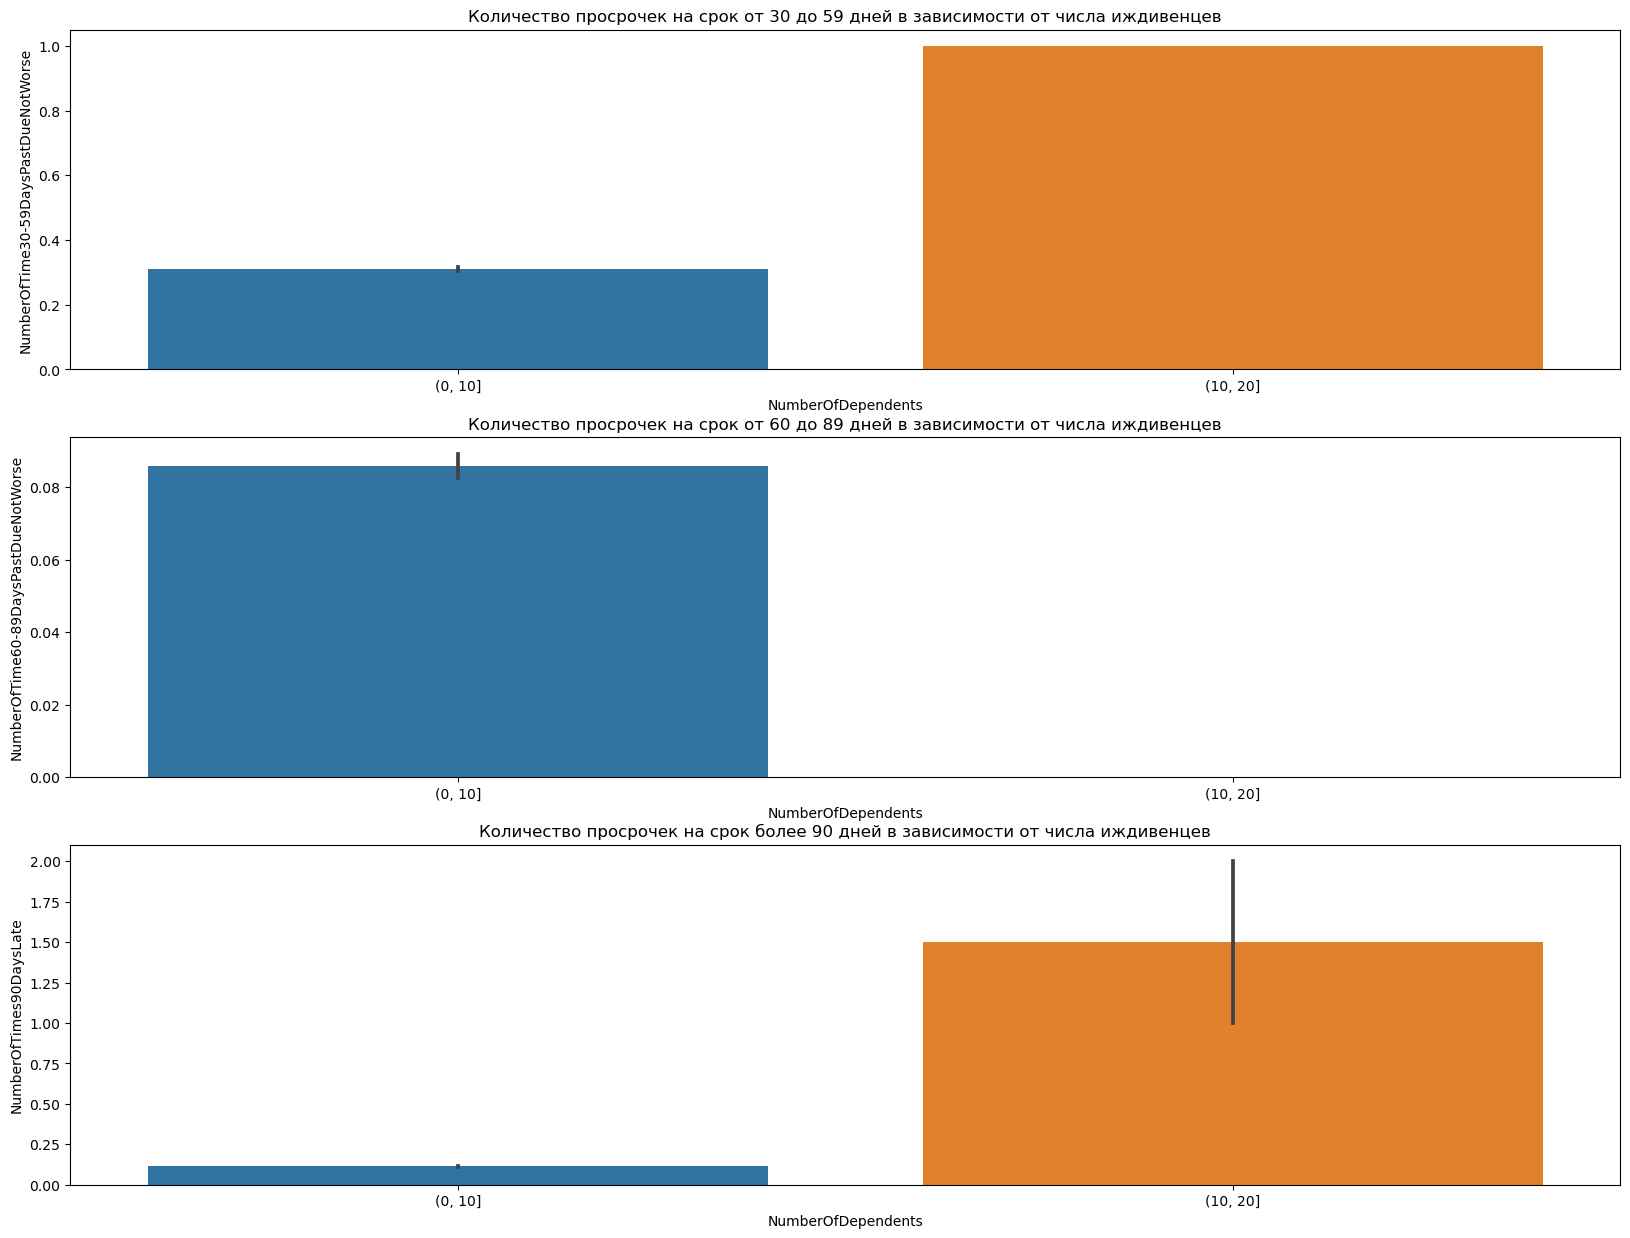

In [459]:
plt.figure(figsize=(20,15))

binned_val = pd.cut(df.NumberOfDependents, 
                   bins = [0,10,20])

plt.subplot (3,1,1)
sns.barplot(data=df, x=binned_val, y='NumberOfTime30-59DaysPastDueNotWorse')
plt.title ('Количество просрочек на срок от 30 до 59 дней в зависимости от числа иждивенцев');


plt.subplot (3,1,2)
sns.barplot(data=df, x=binned_val, y='NumberOfTime60-89DaysPastDueNotWorse')
plt.title ('Количество просрочек на срок от 60 до 89 дней в зависимости от числа иждивенцев');

plt.subplot (3,1,3)
sns.barplot(data=df, x=binned_val, y='NumberOfTimes90DaysLate')
plt.title ('Количество просрочек на срок более 90 дней в зависимости от числа иждивенцев');

##### Итог: Исходя из представленных графиков я бы разбил все случаи на 2 группы: 0-10 - Группа 1, 11-20 - Группа 2

In [460]:
df.loc[(df.NumberOfDependents>=0) & (df.NumberOfDependents<=10), 'BinNumberOfDependents']=1
df.loc[(df.NumberOfDependents>=11), 'BinNumberOfDependents']=2

#### 03. Оценим общее количество открытых кредитных линий общих и по недвижимости

<AxesSubplot: xlabel='NumberRealEstateLoansOrLines', ylabel='count'>

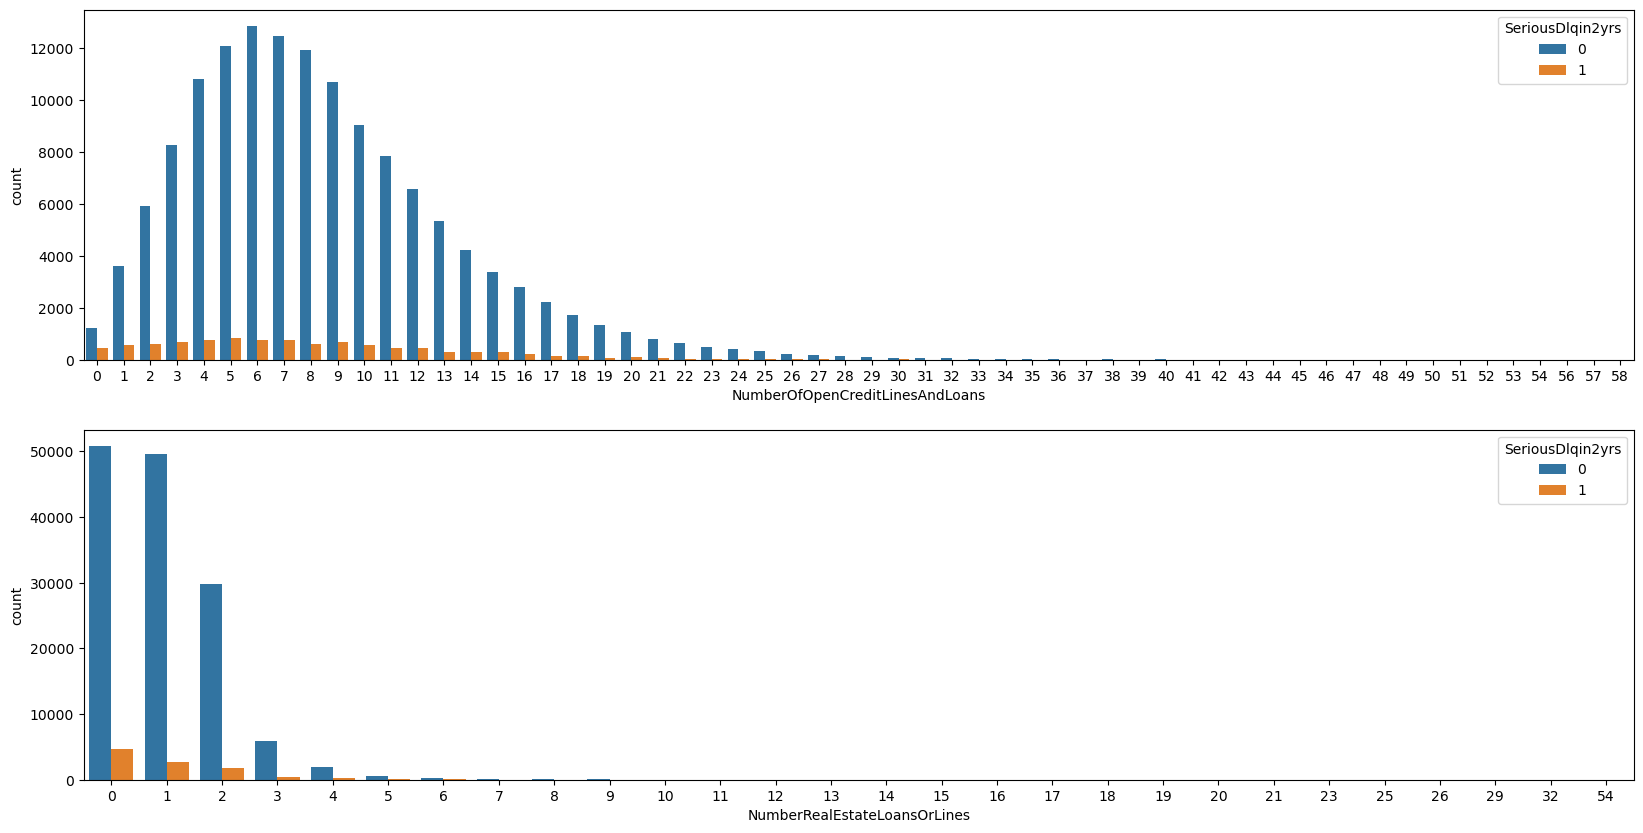

In [461]:
plt.figure(figsize=(20,10))

plt.subplot (2,1,1)
sns.countplot(x=df['NumberOfOpenCreditLinesAndLoans'], hue=df.SeriousDlqin2yrs)

plt.subplot (2,1,2)
sns.countplot(x=df['NumberRealEstateLoansOrLines'], hue=df.SeriousDlqin2yrs)

#### Итог: Исходя из представленных графиков я бы разбил общие кредиты на промежутки: 0-12 - Группа 1, 13-20 - Группа 2, 21 и более - Группа 3.

#### Кредиты на жилье на: 0-2 - Группа 1, 3 и более - Группа 2

In [462]:
df.loc[(df.NumberOfOpenCreditLinesAndLoans>=0) & (df.NumberOfOpenCreditLinesAndLoans<=12), 'BinNumberOfOpenCreditLinesAndLoans']=1
df.loc[(df.NumberOfOpenCreditLinesAndLoans>=13) & (df.NumberOfOpenCreditLinesAndLoans<=20), 'BinNumberOfOpenCreditLinesAndLoans']=2
df.loc[(df.NumberOfOpenCreditLinesAndLoans>=21), 'BinNumberOfOpenCreditLinesAndLoans']=3

In [463]:
df.loc[(df.NumberRealEstateLoansOrLines>=0) & (df.NumberRealEstateLoansOrLines<=2), 'BinNumberRealEstateLoansOrLines']=1
df.loc[(df.NumberRealEstateLoansOrLines>=3), 'BinNumberRealEstateLoansOrLines']=2

<AxesSubplot: xlabel='BinNumberRealEstateLoansOrLines', ylabel='count'>

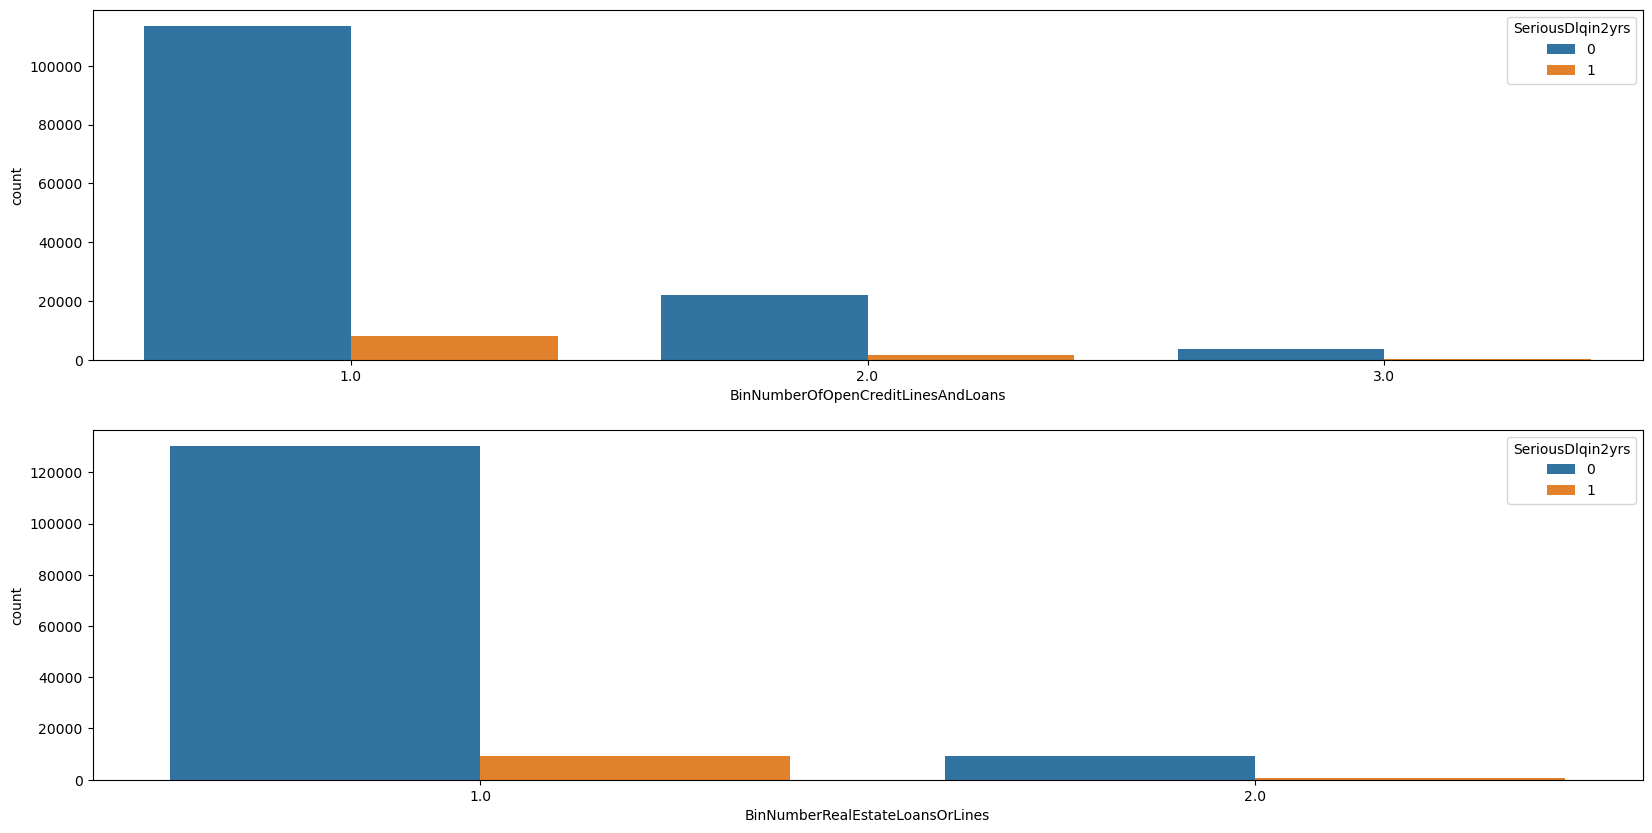

In [464]:
plt.figure(figsize=(20,10))

plt.subplot (2,1,1)
sns.countplot(x=df['BinNumberOfOpenCreditLinesAndLoans'], hue=df.SeriousDlqin2yrs)

plt.subplot (2,1,2)
sns.countplot(x=df['BinNumberRealEstateLoansOrLines'], hue=df.SeriousDlqin2yrs)

### IV. Обучение

### IV.1 Формируем наборы

In [400]:
#df_scaled = pd.DataFrame(MM.fit_transform(df), columns=df.columns)

In [466]:
#,'NumberOfDependents','NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines'
X=df.drop(['SeriousDlqin2yrs'],axis=1)
y=df['SeriousDlqin2yrs']

In [467]:
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.3)

In [468]:
len(X_train)

104461

In [582]:
results = pd.DataFrame(index=['Loss', 'Acc', 'AUC'])

In [470]:
X_train = MM.fit_transform(X_train)
X_val = MM.fit_transform(X_val)
X_test = MM.fit_transform(X_test)

In [471]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

### IV.2 Первая модель. Один скрытый слой, 10 нейронов.

In [567]:
model = Sequential()

model.add(Dense(10, activation='relu', input_dim=len(X.columns)))
model.add(Dense(1, activation='sigmoid', dtype=tf.float64))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', AUC()])

In [568]:
%%time
model_fit = model.fit(X_train, y_train, batch_size=1024, validation_data=(X_val, y_val), epochs=500, use_multiprocessing=True)

Epoch 1/500
103/103 [==============================] - 2s 11ms/step - loss: 0.5326 - accuracy: 0.9109 - auc_92: 0.5637 - val_loss: 0.4069 - val_accuracy: 0.9323 - val_auc_92: 0.6371
Epoch 2/500
103/103 [==============================] - 1s 8ms/step - loss: 0.3372 - accuracy: 0.9329 - auc_92: 0.5982 - val_loss: 0.2766 - val_accuracy: 0.9323 - val_auc_92: 0.6522
Epoch 3/500
103/103 [==============================] - 1s 8ms/step - loss: 0.2579 - accuracy: 0.9330 - auc_92: 0.6650 - val_loss: 0.2397 - val_accuracy: 0.9324 - val_auc_92: 0.6947
Epoch 4/500
103/103 [==============================] - 1s 8ms/step - loss: 0.2321 - accuracy: 0.9333 - auc_92: 0.7117 - val_loss: 0.2238 - val_accuracy: 0.9324 - val_auc_92: 0.7358
Epoch 5/500
103/103 [==============================] - 1s 8ms/step - loss: 0.2189 - accuracy: 0.9338 - auc_92: 0.7557 - val_loss: 0.2135 - val_accuracy: 0.9335 - val_auc_92: 0.7696
Epoch 6/500
103/103 [==============================] - 1s 7ms/step - loss: 0.2110 - accuracy: 

103/103 [==============================] - 1s 8ms/step - loss: 0.1905 - accuracy: 0.9365 - auc_92: 0.8230 - val_loss: 0.1928 - val_accuracy: 0.9358 - val_auc_92: 0.8192
Epoch 47/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1905 - accuracy: 0.9366 - auc_92: 0.8228 - val_loss: 0.1928 - val_accuracy: 0.9359 - val_auc_92: 0.8192
Epoch 48/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1904 - accuracy: 0.9365 - auc_92: 0.8231 - val_loss: 0.1928 - val_accuracy: 0.9360 - val_auc_92: 0.8190
Epoch 49/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1903 - accuracy: 0.9366 - auc_92: 0.8229 - val_loss: 0.1927 - val_accuracy: 0.9359 - val_auc_92: 0.8195
Epoch 50/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1903 - accuracy: 0.9365 - auc_92: 0.8231 - val_loss: 0.1927 - val_accuracy: 0.9359 - val_auc_92: 0.8193
Epoch 51/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1904 - accuracy: 0.9365 -

103/103 [==============================] - 1s 8ms/step - loss: 0.1892 - accuracy: 0.9364 - auc_92: 0.8256 - val_loss: 0.1922 - val_accuracy: 0.9358 - val_auc_92: 0.8213
Epoch 92/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1892 - accuracy: 0.9364 - auc_92: 0.8252 - val_loss: 0.1922 - val_accuracy: 0.9355 - val_auc_92: 0.8215
Epoch 93/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1892 - accuracy: 0.9364 - auc_92: 0.8259 - val_loss: 0.1922 - val_accuracy: 0.9355 - val_auc_92: 0.8210
Epoch 94/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1892 - accuracy: 0.9365 - auc_92: 0.8259 - val_loss: 0.1923 - val_accuracy: 0.9356 - val_auc_92: 0.8212
Epoch 95/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1892 - accuracy: 0.9364 - auc_92: 0.8255 - val_loss: 0.1923 - val_accuracy: 0.9358 - val_auc_92: 0.8216
Epoch 96/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1891 - accuracy: 0.9364 -

Epoch 136/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1889 - accuracy: 0.9367 - auc_92: 0.8266 - val_loss: 0.1922 - val_accuracy: 0.9358 - val_auc_92: 0.8222
Epoch 137/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1888 - accuracy: 0.9365 - auc_92: 0.8269 - val_loss: 0.1923 - val_accuracy: 0.9361 - val_auc_92: 0.8214
Epoch 138/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1888 - accuracy: 0.9367 - auc_92: 0.8267 - val_loss: 0.1922 - val_accuracy: 0.9359 - val_auc_92: 0.8215
Epoch 139/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1887 - accuracy: 0.9367 - auc_92: 0.8274 - val_loss: 0.1923 - val_accuracy: 0.9358 - val_auc_92: 0.8217
Epoch 140/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1887 - accuracy: 0.9367 - auc_92: 0.8273 - val_loss: 0.1924 - val_accuracy: 0.9359 - val_auc_92: 0.8212
Epoch 141/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1888 -

Epoch 181/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1885 - accuracy: 0.9367 - auc_92: 0.8281 - val_loss: 0.1923 - val_accuracy: 0.9357 - val_auc_92: 0.8212
Epoch 182/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1886 - accuracy: 0.9367 - auc_92: 0.8273 - val_loss: 0.1922 - val_accuracy: 0.9357 - val_auc_92: 0.8211
Epoch 183/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1885 - accuracy: 0.9367 - auc_92: 0.8278 - val_loss: 0.1922 - val_accuracy: 0.9356 - val_auc_92: 0.8209
Epoch 184/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1885 - accuracy: 0.9368 - auc_92: 0.8280 - val_loss: 0.1922 - val_accuracy: 0.9355 - val_auc_92: 0.8214
Epoch 185/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1886 - accuracy: 0.9366 - auc_92: 0.8275 - val_loss: 0.1924 - val_accuracy: 0.9358 - val_auc_92: 0.8213
Epoch 186/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1885 -

Epoch 226/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1883 - accuracy: 0.9367 - auc_92: 0.8288 - val_loss: 0.1929 - val_accuracy: 0.9358 - val_auc_92: 0.8206
Epoch 227/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1883 - accuracy: 0.9367 - auc_92: 0.8281 - val_loss: 0.1932 - val_accuracy: 0.9361 - val_auc_92: 0.8205
Epoch 228/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1884 - accuracy: 0.9367 - auc_92: 0.8284 - val_loss: 0.1927 - val_accuracy: 0.9359 - val_auc_92: 0.8210
Epoch 229/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1883 - accuracy: 0.9367 - auc_92: 0.8288 - val_loss: 0.1925 - val_accuracy: 0.9357 - val_auc_92: 0.8207
Epoch 230/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1883 - accuracy: 0.9367 - auc_92: 0.8285 - val_loss: 0.1930 - val_accuracy: 0.9359 - val_auc_92: 0.8210
Epoch 231/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1883 -

Epoch 271/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1882 - accuracy: 0.9368 - auc_92: 0.8292 - val_loss: 0.1932 - val_accuracy: 0.9361 - val_auc_92: 0.8205
Epoch 272/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1882 - accuracy: 0.9368 - auc_92: 0.8292 - val_loss: 0.1931 - val_accuracy: 0.9360 - val_auc_92: 0.8205
Epoch 273/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1882 - accuracy: 0.9369 - auc_92: 0.8292 - val_loss: 0.1931 - val_accuracy: 0.9360 - val_auc_92: 0.8202
Epoch 274/500
103/103 [==============================] - 1s 7ms/step - loss: 0.1881 - accuracy: 0.9368 - auc_92: 0.8289 - val_loss: 0.1932 - val_accuracy: 0.9359 - val_auc_92: 0.8204
Epoch 275/500
103/103 [==============================] - 1s 7ms/step - loss: 0.1882 - accuracy: 0.9369 - auc_92: 0.8293 - val_loss: 0.1929 - val_accuracy: 0.9359 - val_auc_92: 0.8202
Epoch 276/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1881 -

Epoch 316/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1881 - accuracy: 0.9368 - auc_92: 0.8295 - val_loss: 0.1937 - val_accuracy: 0.9361 - val_auc_92: 0.8198
Epoch 317/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1881 - accuracy: 0.9366 - auc_92: 0.8297 - val_loss: 0.1938 - val_accuracy: 0.9359 - val_auc_92: 0.8200
Epoch 318/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1880 - accuracy: 0.9368 - auc_92: 0.8295 - val_loss: 0.1934 - val_accuracy: 0.9360 - val_auc_92: 0.8202
Epoch 319/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1880 - accuracy: 0.9367 - auc_92: 0.8297 - val_loss: 0.1932 - val_accuracy: 0.9359 - val_auc_92: 0.8201
Epoch 320/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1883 - accuracy: 0.9367 - auc_92: 0.8293 - val_loss: 0.1933 - val_accuracy: 0.9361 - val_auc_92: 0.8200
Epoch 321/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1880 -

Epoch 361/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1880 - accuracy: 0.9367 - auc_92: 0.8301 - val_loss: 0.1938 - val_accuracy: 0.9359 - val_auc_92: 0.8193
Epoch 362/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1880 - accuracy: 0.9369 - auc_92: 0.8303 - val_loss: 0.1941 - val_accuracy: 0.9358 - val_auc_92: 0.8197
Epoch 363/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1880 - accuracy: 0.9368 - auc_92: 0.8299 - val_loss: 0.1940 - val_accuracy: 0.9358 - val_auc_92: 0.8198
Epoch 364/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1880 - accuracy: 0.9368 - auc_92: 0.8301 - val_loss: 0.1939 - val_accuracy: 0.9358 - val_auc_92: 0.8195
Epoch 365/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1880 - accuracy: 0.9369 - auc_92: 0.8300 - val_loss: 0.1938 - val_accuracy: 0.9359 - val_auc_92: 0.8196
Epoch 366/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1880 -

Epoch 406/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1879 - accuracy: 0.9368 - auc_92: 0.8305 - val_loss: 0.1940 - val_accuracy: 0.9357 - val_auc_92: 0.8191
Epoch 407/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1879 - accuracy: 0.9367 - auc_92: 0.8304 - val_loss: 0.1943 - val_accuracy: 0.9355 - val_auc_92: 0.8189
Epoch 408/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1879 - accuracy: 0.9369 - auc_92: 0.8302 - val_loss: 0.1938 - val_accuracy: 0.9358 - val_auc_92: 0.8194
Epoch 409/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1879 - accuracy: 0.9369 - auc_92: 0.8303 - val_loss: 0.1943 - val_accuracy: 0.9358 - val_auc_92: 0.8191
Epoch 410/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1879 - accuracy: 0.9368 - auc_92: 0.8307 - val_loss: 0.1937 - val_accuracy: 0.9357 - val_auc_92: 0.8194
Epoch 411/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1881 -

Epoch 451/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1879 - accuracy: 0.9368 - auc_92: 0.8308 - val_loss: 0.1948 - val_accuracy: 0.9356 - val_auc_92: 0.8186
Epoch 452/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1879 - accuracy: 0.9367 - auc_92: 0.8302 - val_loss: 0.1944 - val_accuracy: 0.9358 - val_auc_92: 0.8187
Epoch 453/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1878 - accuracy: 0.9366 - auc_92: 0.8304 - val_loss: 0.1941 - val_accuracy: 0.9358 - val_auc_92: 0.8188
Epoch 454/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1878 - accuracy: 0.9368 - auc_92: 0.8305 - val_loss: 0.1941 - val_accuracy: 0.9359 - val_auc_92: 0.8182
Epoch 455/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1878 - accuracy: 0.9367 - auc_92: 0.8309 - val_loss: 0.1943 - val_accuracy: 0.9358 - val_auc_92: 0.8189
Epoch 456/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1878 -

Epoch 496/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1877 - accuracy: 0.9368 - auc_92: 0.8311 - val_loss: 0.1943 - val_accuracy: 0.9357 - val_auc_92: 0.8181
Epoch 497/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1877 - accuracy: 0.9367 - auc_92: 0.8312 - val_loss: 0.1944 - val_accuracy: 0.9356 - val_auc_92: 0.8181
Epoch 498/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1877 - accuracy: 0.9369 - auc_92: 0.8310 - val_loss: 0.1940 - val_accuracy: 0.9358 - val_auc_92: 0.8185
Epoch 499/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1877 - accuracy: 0.9368 - auc_92: 0.8312 - val_loss: 0.1942 - val_accuracy: 0.9355 - val_auc_92: 0.8182
Epoch 500/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1877 - accuracy: 0.9368 - auc_92: 0.8312 - val_loss: 0.1944 - val_accuracy: 0.9356 - val_auc_92: 0.8180
CPU times: total: 10min 21s
Wall time: 7min 3s


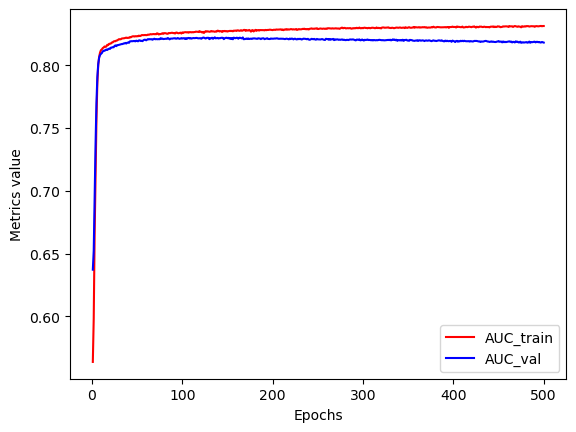

In [586]:
history = model_fit

keys_list = list(history.history.keys())

loss = history.history[keys_list[0]]
acc = history.history[keys_list[1]]
auc = history.history[keys_list[2]]

val_loss = history.history[keys_list[3]]
val_acc = history.history[keys_list[4]]
val_auc = history.history[keys_list[5]]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, auc, 'r', label='AUC_train')
plt.plot(epochs, val_auc, 'b', label='AUC_val')
plt.xlabel('Epochs')
plt.ylabel('Metrics value')
plt.legend()
plt.show()

results['Model1 (1H - 10) (Val)'] = np.array([min(val_loss),
                                              max(val_acc),
                                              max(val_auc)])
results['Model1 (1H - 10) (Train)'] = np.array([min(loss),
                                              max(acc),
                                              max(auc)])

In [584]:
results['Model1 (1H - 10) (Test)'] = model.evaluate(X_test, y_test)

420/420 [==============================] - 2s 5ms/step - loss: 0.1927 - accuracy: 0.9334 - auc_92: 0.8231


In [585]:
results

,Model1 (1H - 10) (Val),Model1 (1H - 10) (Train),Model1 (1H - 10) (Test)
Loss,0.192061,0.187703,0.192678
Acc,0.936533,0.936962,0.933363
AUC,0.822155,0.831246,0.823097


### Итог: 

Нейронная сеть с одним скрытым слоем из 10 нейронов продемонстрировала следующие максимальные результаты на тренировочном сете - 83.12, валидационном сете - 82.21, тестовом сете - 82.30. Причем видно, что результат на тестовом наборе возрастал все время обучения, тогда как на валидационном наборе начал уменьшаться после 70-й эпохи.

### IV.2 Вторая модель. Один скрытый слой, 750 нейронов.

In [587]:
model2 = Sequential()

model2.add(Dense(750, activation='relu', input_dim=len(X.columns)))

model2.add(Dense(1, activation='sigmoid', dtype=tf.float64))

model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', AUC()])

In [588]:
%%time
model_fit2 = model2.fit(X_train, y_train, batch_size=1024, validation_data=(X_val, y_val), epochs=500, use_multiprocessing=True)

Epoch 1/500
103/103 [==============================] - 2s 14ms/step - loss: 0.3068 - accuracy: 0.9319 - auc_93: 0.5995 - val_loss: 0.2099 - val_accuracy: 0.9337 - val_auc_93: 0.7904
Epoch 2/500
103/103 [==============================] - 1s 8ms/step - loss: 0.2030 - accuracy: 0.9352 - auc_93: 0.8057 - val_loss: 0.1990 - val_accuracy: 0.9364 - val_auc_93: 0.8114
Epoch 3/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1976 - accuracy: 0.9361 - auc_93: 0.8149 - val_loss: 0.1969 - val_accuracy: 0.9358 - val_auc_93: 0.8146
Epoch 4/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1945 - accuracy: 0.9361 - auc_93: 0.8179 - val_loss: 0.1947 - val_accuracy: 0.9364 - val_auc_93: 0.8158
Epoch 5/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1925 - accuracy: 0.9365 - auc_93: 0.8196 - val_loss: 0.1938 - val_accuracy: 0.9364 - val_auc_93: 0.8163
Epoch 6/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1916 - accuracy: 

103/103 [==============================] - 1s 8ms/step - loss: 0.1889 - accuracy: 0.9365 - auc_93: 0.8274 - val_loss: 0.1925 - val_accuracy: 0.9355 - val_auc_93: 0.8238
Epoch 47/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1877 - accuracy: 0.9368 - auc_93: 0.8301 - val_loss: 0.1921 - val_accuracy: 0.9356 - val_auc_93: 0.8231
Epoch 48/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1877 - accuracy: 0.9368 - auc_93: 0.8306 - val_loss: 0.1923 - val_accuracy: 0.9354 - val_auc_93: 0.8230
Epoch 49/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1876 - accuracy: 0.9370 - auc_93: 0.8309 - val_loss: 0.1923 - val_accuracy: 0.9358 - val_auc_93: 0.8222
Epoch 50/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1879 - accuracy: 0.9366 - auc_93: 0.8302 - val_loss: 0.1922 - val_accuracy: 0.9354 - val_auc_93: 0.8231
Epoch 51/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1882 - accuracy: 0.9366 -

103/103 [==============================] - 1s 9ms/step - loss: 0.1867 - accuracy: 0.9371 - auc_93: 0.8333 - val_loss: 0.1929 - val_accuracy: 0.9355 - val_auc_93: 0.8230
Epoch 92/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1867 - accuracy: 0.9368 - auc_93: 0.8339 - val_loss: 0.1926 - val_accuracy: 0.9358 - val_auc_93: 0.8233
Epoch 93/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1869 - accuracy: 0.9369 - auc_93: 0.8329 - val_loss: 0.1924 - val_accuracy: 0.9358 - val_auc_93: 0.8238
Epoch 94/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1865 - accuracy: 0.9373 - auc_93: 0.8343 - val_loss: 0.1950 - val_accuracy: 0.9355 - val_auc_93: 0.8231
Epoch 95/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1867 - accuracy: 0.9370 - auc_93: 0.8336 - val_loss: 0.1937 - val_accuracy: 0.9354 - val_auc_93: 0.8243
Epoch 96/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1866 - accuracy: 0.9370 -

Epoch 136/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1865 - accuracy: 0.9369 - auc_93: 0.8338 - val_loss: 0.1930 - val_accuracy: 0.9355 - val_auc_93: 0.8253
Epoch 137/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1859 - accuracy: 0.9371 - auc_93: 0.8355 - val_loss: 0.1937 - val_accuracy: 0.9355 - val_auc_93: 0.8240
Epoch 138/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1860 - accuracy: 0.9372 - auc_93: 0.8352 - val_loss: 0.1933 - val_accuracy: 0.9353 - val_auc_93: 0.8235
Epoch 139/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1859 - accuracy: 0.9372 - auc_93: 0.8353 - val_loss: 0.1949 - val_accuracy: 0.9357 - val_auc_93: 0.8243
Epoch 140/500
103/103 [==============================] - 1s 7ms/step - loss: 0.1863 - accuracy: 0.9367 - auc_93: 0.8348 - val_loss: 0.1922 - val_accuracy: 0.9354 - val_auc_93: 0.8251
Epoch 141/500
103/103 [==============================] - 1s 7ms/step - loss: 0.1860 -

Epoch 181/500
103/103 [==============================] - 1s 7ms/step - loss: 0.1855 - accuracy: 0.9373 - auc_93: 0.8365 - val_loss: 0.1949 - val_accuracy: 0.9358 - val_auc_93: 0.8237
Epoch 182/500
103/103 [==============================] - 1s 7ms/step - loss: 0.1854 - accuracy: 0.9375 - auc_93: 0.8366 - val_loss: 0.1949 - val_accuracy: 0.9356 - val_auc_93: 0.8230
Epoch 183/500
103/103 [==============================] - 1s 7ms/step - loss: 0.1855 - accuracy: 0.9374 - auc_93: 0.8358 - val_loss: 0.1938 - val_accuracy: 0.9351 - val_auc_93: 0.8239
Epoch 184/500
103/103 [==============================] - 1s 7ms/step - loss: 0.1860 - accuracy: 0.9375 - auc_93: 0.8351 - val_loss: 0.1947 - val_accuracy: 0.9357 - val_auc_93: 0.8239
Epoch 185/500
103/103 [==============================] - 1s 7ms/step - loss: 0.1853 - accuracy: 0.9374 - auc_93: 0.8368 - val_loss: 0.1947 - val_accuracy: 0.9357 - val_auc_93: 0.8233
Epoch 186/500
103/103 [==============================] - 1s 7ms/step - loss: 0.1855 -

Epoch 226/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1856 - accuracy: 0.9379 - auc_93: 0.8347 - val_loss: 0.1945 - val_accuracy: 0.9357 - val_auc_93: 0.8236
Epoch 227/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1849 - accuracy: 0.9375 - auc_93: 0.8374 - val_loss: 0.1947 - val_accuracy: 0.9355 - val_auc_93: 0.8223
Epoch 228/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1849 - accuracy: 0.9378 - auc_93: 0.8374 - val_loss: 0.1942 - val_accuracy: 0.9355 - val_auc_93: 0.8227
Epoch 229/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1849 - accuracy: 0.9376 - auc_93: 0.8376 - val_loss: 0.1953 - val_accuracy: 0.9359 - val_auc_93: 0.8230
Epoch 230/500
103/103 [==============================] - 1s 7ms/step - loss: 0.1849 - accuracy: 0.9375 - auc_93: 0.8371 - val_loss: 0.1961 - val_accuracy: 0.9355 - val_auc_93: 0.8225
Epoch 231/500
103/103 [==============================] - 1s 7ms/step - loss: 0.1848 -

Epoch 271/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1843 - accuracy: 0.9378 - auc_93: 0.8390 - val_loss: 0.1955 - val_accuracy: 0.9355 - val_auc_93: 0.8217
Epoch 272/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1844 - accuracy: 0.9377 - auc_93: 0.8387 - val_loss: 0.1973 - val_accuracy: 0.9358 - val_auc_93: 0.8206
Epoch 273/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1846 - accuracy: 0.9378 - auc_93: 0.8379 - val_loss: 0.1957 - val_accuracy: 0.9354 - val_auc_93: 0.8204
Epoch 274/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1843 - accuracy: 0.9378 - auc_93: 0.8391 - val_loss: 0.1977 - val_accuracy: 0.9353 - val_auc_93: 0.8199
Epoch 275/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1848 - accuracy: 0.9377 - auc_93: 0.8376 - val_loss: 0.1954 - val_accuracy: 0.9356 - val_auc_93: 0.8214
Epoch 276/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1844 -

Epoch 316/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1841 - accuracy: 0.9379 - auc_93: 0.8389 - val_loss: 0.1959 - val_accuracy: 0.9357 - val_auc_93: 0.8209
Epoch 317/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1839 - accuracy: 0.9378 - auc_93: 0.8394 - val_loss: 0.1962 - val_accuracy: 0.9355 - val_auc_93: 0.8201
Epoch 318/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1841 - accuracy: 0.9380 - auc_93: 0.8387 - val_loss: 0.1961 - val_accuracy: 0.9349 - val_auc_93: 0.8196
Epoch 319/500
103/103 [==============================] - 1s 7ms/step - loss: 0.1845 - accuracy: 0.9379 - auc_93: 0.8378 - val_loss: 0.1964 - val_accuracy: 0.9350 - val_auc_93: 0.8198
Epoch 320/500
103/103 [==============================] - 1s 7ms/step - loss: 0.1840 - accuracy: 0.9380 - auc_93: 0.8392 - val_loss: 0.1962 - val_accuracy: 0.9349 - val_auc_93: 0.8181
Epoch 321/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1840 -

Epoch 361/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1836 - accuracy: 0.9380 - auc_93: 0.8395 - val_loss: 0.1983 - val_accuracy: 0.9350 - val_auc_93: 0.8139
Epoch 362/500
103/103 [==============================] - 1s 7ms/step - loss: 0.1841 - accuracy: 0.9382 - auc_93: 0.8392 - val_loss: 0.1966 - val_accuracy: 0.9347 - val_auc_93: 0.8191
Epoch 363/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1839 - accuracy: 0.9379 - auc_93: 0.8389 - val_loss: 0.1974 - val_accuracy: 0.9347 - val_auc_93: 0.8177
Epoch 364/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1836 - accuracy: 0.9381 - auc_93: 0.8403 - val_loss: 0.1967 - val_accuracy: 0.9352 - val_auc_93: 0.8172
Epoch 365/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1833 - accuracy: 0.9383 - auc_93: 0.8409 - val_loss: 0.1964 - val_accuracy: 0.9354 - val_auc_93: 0.8182
Epoch 366/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1834 -

Epoch 406/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1835 - accuracy: 0.9383 - auc_93: 0.8397 - val_loss: 0.1979 - val_accuracy: 0.9350 - val_auc_93: 0.8148
Epoch 407/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1830 - accuracy: 0.9384 - auc_93: 0.8413 - val_loss: 0.1981 - val_accuracy: 0.9351 - val_auc_93: 0.8157
Epoch 408/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1833 - accuracy: 0.9381 - auc_93: 0.8412 - val_loss: 0.1974 - val_accuracy: 0.9352 - val_auc_93: 0.8162
Epoch 409/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1829 - accuracy: 0.9386 - auc_93: 0.8417 - val_loss: 0.1982 - val_accuracy: 0.9355 - val_auc_93: 0.8149
Epoch 410/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1830 - accuracy: 0.9385 - auc_93: 0.8412 - val_loss: 0.1989 - val_accuracy: 0.9349 - val_auc_93: 0.8140
Epoch 411/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1829 -

Epoch 451/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1826 - accuracy: 0.9386 - auc_93: 0.8422 - val_loss: 0.1999 - val_accuracy: 0.9345 - val_auc_93: 0.8110
Epoch 452/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1827 - accuracy: 0.9387 - auc_93: 0.8414 - val_loss: 0.1998 - val_accuracy: 0.9350 - val_auc_93: 0.8094
Epoch 453/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1830 - accuracy: 0.9387 - auc_93: 0.8404 - val_loss: 0.2003 - val_accuracy: 0.9344 - val_auc_93: 0.8104
Epoch 454/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1827 - accuracy: 0.9388 - auc_93: 0.8419 - val_loss: 0.1999 - val_accuracy: 0.9347 - val_auc_93: 0.8095
Epoch 455/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1828 - accuracy: 0.9387 - auc_93: 0.8414 - val_loss: 0.2006 - val_accuracy: 0.9349 - val_auc_93: 0.8094
Epoch 456/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1825 -

Epoch 496/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1821 - accuracy: 0.9388 - auc_93: 0.8436 - val_loss: 0.2026 - val_accuracy: 0.9346 - val_auc_93: 0.8069
Epoch 497/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1822 - accuracy: 0.9388 - auc_93: 0.8437 - val_loss: 0.2025 - val_accuracy: 0.9338 - val_auc_93: 0.8075
Epoch 498/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1830 - accuracy: 0.9390 - auc_93: 0.8408 - val_loss: 0.2031 - val_accuracy: 0.9343 - val_auc_93: 0.8031
Epoch 499/500
103/103 [==============================] - 1s 9ms/step - loss: 0.1824 - accuracy: 0.9388 - auc_93: 0.8427 - val_loss: 0.2022 - val_accuracy: 0.9353 - val_auc_93: 0.8061
Epoch 500/500
103/103 [==============================] - 1s 8ms/step - loss: 0.1820 - accuracy: 0.9389 - auc_93: 0.8437 - val_loss: 0.2024 - val_accuracy: 0.9350 - val_auc_93: 0.8066
CPU times: total: 9min 48s
Wall time: 6min 53s


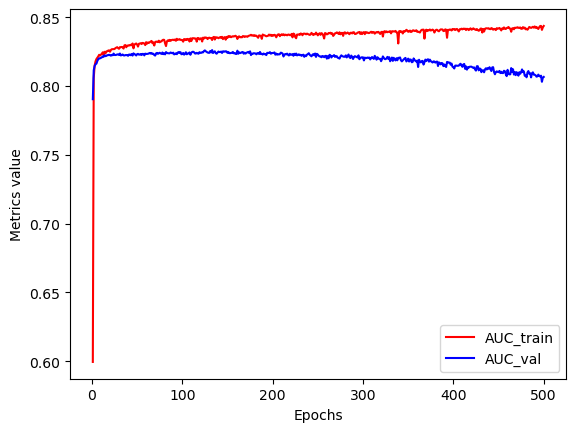

In [590]:
history = model_fit2

keys_list = list(history.history.keys())

loss = history.history[keys_list[0]]
acc = history.history[keys_list[1]]
auc = history.history[keys_list[2]]

val_loss = history.history[keys_list[3]]
val_acc = history.history[keys_list[4]]
val_auc = history.history[keys_list[5]]



epochs = range(1, len(acc) + 1)
plt.plot(epochs, auc, 'r', label='AUC_train')
plt.plot(epochs, val_auc, 'b', label='AUC_val')
plt.xlabel('Epochs')
plt.ylabel('Metrics value')
plt.legend()
plt.show()

results['Model2 (1H - 750) (Train)'] = np.array([min(loss),
                                              max(acc),
                                              max(auc)])

results['Model2 (1H - 750) (Val)'] = np.array([min(val_loss),
                                              max(val_acc),
                                              max(val_auc)])

In [591]:
results['Model2 (1H - 750) (Test)'] = model2.evaluate(X_test, y_test)

420/420 [==============================] - 2s 5ms/step - loss: 0.2257 - accuracy: 0.9256 - auc_93: 0.7897


### Итог: 

С увеличением количества нейроов мы можем наблюдать рост результатов на тренировочной выборке до 84.37, тогда как на валидационной и тестовой отмечается падение до 82.6 и 78.96. Причем, расхождение кривых валидационной и тестовой выборки мы уже можем видеть в самом начале после приблизительно 20й эпохи

##### IV.3 Третья модель. Два скрытых слоя, 512-512 нейронов.

In [593]:
model3 = Sequential()

model3.add(Dense(512, activation='relu', input_dim=len(X.columns)))

model3.add(Dense(512, activation='relu'))

model3.add(Dense(1, activation='sigmoid', dtype=tf.float64))

model3.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', AUC()])

In [617]:
model_fit3 = model3.fit(X_train, y_train, batch_size=len(X_train), validation_data=(X_val, y_val), epochs=300, use_multiprocessing=True)

Epoch 1/300
1/1 [==============================] - 0s 406ms/step - loss: 0.1661 - accuracy: 0.9467 - auc_94: 0.8639 - val_loss: 0.2758 - val_accuracy: 0.9309 - val_auc_94: 0.7548
Epoch 2/300
1/1 [==============================] - 0s 123ms/step - loss: 0.1670 - accuracy: 0.9464 - auc_94: 0.8629 - val_loss: 0.2783 - val_accuracy: 0.9305 - val_auc_94: 0.7537
Epoch 3/300
1/1 [==============================] - 0s 123ms/step - loss: 0.1683 - accuracy: 0.9456 - auc_94: 0.8615 - val_loss: 0.2810 - val_accuracy: 0.9299 - val_auc_94: 0.7527
Epoch 4/300
1/1 [==============================] - 0s 114ms/step - loss: 0.1698 - accuracy: 0.9446 - auc_94: 0.8599 - val_loss: 0.2835 - val_accuracy: 0.9294 - val_auc_94: 0.7516
Epoch 5/300
1/1 [==============================] - 0s 120ms/step - loss: 0.1712 - accuracy: 0.9439 - auc_94: 0.8587 - val_loss: 0.2858 - val_accuracy: 0.9293 - val_auc_94: 0.7505
Epoch 6/300
1/1 [==============================] - 0s 116ms/step - loss: 0.1723 - accuracy: 0.9433 - auc_

1/1 [==============================] - 0s 116ms/step - loss: 0.1654 - accuracy: 0.9469 - auc_94: 0.8648 - val_loss: 0.2780 - val_accuracy: 0.9316 - val_auc_94: 0.7513
Epoch 47/300
1/1 [==============================] - 0s 114ms/step - loss: 0.1654 - accuracy: 0.9469 - auc_94: 0.8650 - val_loss: 0.2783 - val_accuracy: 0.9316 - val_auc_94: 0.7507
Epoch 48/300
1/1 [==============================] - 0s 113ms/step - loss: 0.1653 - accuracy: 0.9469 - auc_94: 0.8651 - val_loss: 0.2785 - val_accuracy: 0.9317 - val_auc_94: 0.7501
Epoch 49/300
1/1 [==============================] - 0s 117ms/step - loss: 0.1653 - accuracy: 0.9470 - auc_94: 0.8651 - val_loss: 0.2787 - val_accuracy: 0.9318 - val_auc_94: 0.7496
Epoch 50/300
1/1 [==============================] - 0s 121ms/step - loss: 0.1652 - accuracy: 0.9470 - auc_94: 0.8652 - val_loss: 0.2788 - val_accuracy: 0.9320 - val_auc_94: 0.7488
Epoch 51/300
1/1 [==============================] - 0s 118ms/step - loss: 0.1652 - accuracy: 0.9470 - auc_94: 0.8

1/1 [==============================] - 0s 116ms/step - loss: 0.1644 - accuracy: 0.9474 - auc_94: 0.8663 - val_loss: 0.2779 - val_accuracy: 0.9323 - val_auc_94: 0.7503
Epoch 92/300
1/1 [==============================] - 0s 113ms/step - loss: 0.1644 - accuracy: 0.9474 - auc_94: 0.8664 - val_loss: 0.2779 - val_accuracy: 0.9323 - val_auc_94: 0.7503
Epoch 93/300
1/1 [==============================] - 0s 115ms/step - loss: 0.1644 - accuracy: 0.9474 - auc_94: 0.8664 - val_loss: 0.2780 - val_accuracy: 0.9323 - val_auc_94: 0.7502
Epoch 94/300
1/1 [==============================] - 0s 112ms/step - loss: 0.1644 - accuracy: 0.9474 - auc_94: 0.8664 - val_loss: 0.2780 - val_accuracy: 0.9324 - val_auc_94: 0.7503
Epoch 95/300
1/1 [==============================] - 0s 115ms/step - loss: 0.1644 - accuracy: 0.9474 - auc_94: 0.8664 - val_loss: 0.2780 - val_accuracy: 0.9323 - val_auc_94: 0.7504
Epoch 96/300
1/1 [==============================] - 0s 111ms/step - loss: 0.1644 - accuracy: 0.9474 - auc_94: 0.8

1/1 [==============================] - 0s 114ms/step - loss: 0.1641 - accuracy: 0.9475 - auc_94: 0.8669 - val_loss: 0.2786 - val_accuracy: 0.9323 - val_auc_94: 0.7499
Epoch 137/300
1/1 [==============================] - 0s 115ms/step - loss: 0.1641 - accuracy: 0.9476 - auc_94: 0.8669 - val_loss: 0.2786 - val_accuracy: 0.9324 - val_auc_94: 0.7499
Epoch 138/300
1/1 [==============================] - 0s 115ms/step - loss: 0.1641 - accuracy: 0.9476 - auc_94: 0.8669 - val_loss: 0.2786 - val_accuracy: 0.9324 - val_auc_94: 0.7498
Epoch 139/300
1/1 [==============================] - 0s 114ms/step - loss: 0.1641 - accuracy: 0.9475 - auc_94: 0.8669 - val_loss: 0.2787 - val_accuracy: 0.9324 - val_auc_94: 0.7498
Epoch 140/300
1/1 [==============================] - 0s 113ms/step - loss: 0.1641 - accuracy: 0.9475 - auc_94: 0.8669 - val_loss: 0.2787 - val_accuracy: 0.9323 - val_auc_94: 0.7498
Epoch 141/300
1/1 [==============================] - 0s 113ms/step - loss: 0.1641 - accuracy: 0.9475 - auc_94

1/1 [==============================] - 0s 113ms/step - loss: 0.1639 - accuracy: 0.9476 - auc_94: 0.8672 - val_loss: 0.2792 - val_accuracy: 0.9322 - val_auc_94: 0.7495
Epoch 182/300
1/1 [==============================] - 0s 117ms/step - loss: 0.1639 - accuracy: 0.9476 - auc_94: 0.8672 - val_loss: 0.2792 - val_accuracy: 0.9322 - val_auc_94: 0.7494
Epoch 183/300
1/1 [==============================] - 0s 113ms/step - loss: 0.1639 - accuracy: 0.9476 - auc_94: 0.8672 - val_loss: 0.2792 - val_accuracy: 0.9322 - val_auc_94: 0.7494
Epoch 184/300
1/1 [==============================] - 0s 123ms/step - loss: 0.1639 - accuracy: 0.9476 - auc_94: 0.8673 - val_loss: 0.2793 - val_accuracy: 0.9322 - val_auc_94: 0.7494
Epoch 185/300
1/1 [==============================] - 0s 116ms/step - loss: 0.1639 - accuracy: 0.9476 - auc_94: 0.8673 - val_loss: 0.2793 - val_accuracy: 0.9322 - val_auc_94: 0.7495
Epoch 186/300
1/1 [==============================] - 0s 117ms/step - loss: 0.1639 - accuracy: 0.9476 - auc_94

1/1 [==============================] - 0s 115ms/step - loss: 0.1637 - accuracy: 0.9477 - auc_94: 0.8675 - val_loss: 0.2799 - val_accuracy: 0.9321 - val_auc_94: 0.7490
Epoch 227/300
1/1 [==============================] - 0s 113ms/step - loss: 0.1637 - accuracy: 0.9477 - auc_94: 0.8675 - val_loss: 0.2799 - val_accuracy: 0.9321 - val_auc_94: 0.7490
Epoch 228/300
1/1 [==============================] - 0s 114ms/step - loss: 0.1637 - accuracy: 0.9477 - auc_94: 0.8675 - val_loss: 0.2800 - val_accuracy: 0.9321 - val_auc_94: 0.7490
Epoch 229/300
1/1 [==============================] - 0s 117ms/step - loss: 0.1637 - accuracy: 0.9477 - auc_94: 0.8675 - val_loss: 0.2800 - val_accuracy: 0.9321 - val_auc_94: 0.7489
Epoch 230/300
1/1 [==============================] - 0s 113ms/step - loss: 0.1637 - accuracy: 0.9477 - auc_94: 0.8675 - val_loss: 0.2800 - val_accuracy: 0.9321 - val_auc_94: 0.7489
Epoch 231/300
1/1 [==============================] - 0s 114ms/step - loss: 0.1637 - accuracy: 0.9477 - auc_94

1/1 [==============================] - 0s 113ms/step - loss: 0.1636 - accuracy: 0.9477 - auc_94: 0.8677 - val_loss: 0.2808 - val_accuracy: 0.9322 - val_auc_94: 0.7483
Epoch 272/300
1/1 [==============================] - 0s 115ms/step - loss: 0.1636 - accuracy: 0.9477 - auc_94: 0.8677 - val_loss: 0.2808 - val_accuracy: 0.9322 - val_auc_94: 0.7484
Epoch 273/300
1/1 [==============================] - 0s 113ms/step - loss: 0.1636 - accuracy: 0.9477 - auc_94: 0.8678 - val_loss: 0.2808 - val_accuracy: 0.9322 - val_auc_94: 0.7483
Epoch 274/300
1/1 [==============================] - 0s 117ms/step - loss: 0.1635 - accuracy: 0.9477 - auc_94: 0.8677 - val_loss: 0.2808 - val_accuracy: 0.9322 - val_auc_94: 0.7482
Epoch 275/300
1/1 [==============================] - 0s 112ms/step - loss: 0.1635 - accuracy: 0.9477 - auc_94: 0.8677 - val_loss: 0.2808 - val_accuracy: 0.9322 - val_auc_94: 0.7482
Epoch 276/300
1/1 [==============================] - 0s 112ms/step - loss: 0.1635 - accuracy: 0.9477 - auc_94

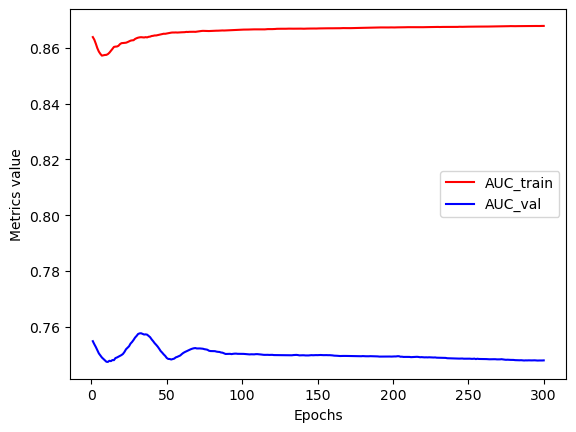

In [618]:
history = model_fit3

keys_list = list(history.history.keys())

loss = history.history[keys_list[0]]
acc = history.history[keys_list[1]]
auc = history.history[keys_list[2]]

val_loss = history.history[keys_list[3]]
val_acc = history.history[keys_list[4]]
val_auc = history.history[keys_list[5]]



epochs = range(1, len(acc) + 1)
plt.plot(epochs, auc, 'r', label='AUC_train')
plt.plot(epochs, val_auc, 'b', label='AUC_val')
plt.xlabel('Epochs')
plt.ylabel('Metrics value')
plt.legend()
plt.show()

results['Model3 (2H - 512-512) (Train)'] = np.array([min(loss),
                                              max(acc),
                                              max(auc)])
results['Model3 (2H - 512-512) (Val)'] = np.array([min(val_loss),
                                              max(val_acc),
                                              max(val_auc)])

In [619]:
results['Model3 (2H - 512-512) (Test)']= model3.evaluate(X_test, y_test)

420/420 [==============================] - 2s 5ms/step - loss: 0.4410 - accuracy: 0.9258 - auc_94: 0.7132


In [620]:
results[['Model3 (2H - 512-512) (Test)', 'Model3 (2H - 512-512) (Train)', 'Model3 (2H - 512-512) (Val)']]

,Model3 (2H - 512-512) (Test),Model3 (2H - 512-512) (Train),Model3 (2H - 512-512) (Val)
Loss,0.441001,0.163468,0.274260
Acc,0.925769,0.947732,0.932416
AUC,0.713178,0.867879,0.757689


### Итог: 

И снова та же самая картина. Усложнение модели ведет к росту показателей тренировочного сета, тогда как на тестовом и валидационном - снижение.

### IV.4  Четвертая модель. Три скрытых слоя, 512-512-512 нейронов.

In [621]:
model4 = Sequential()

model4.add(Dense(512, activation='relu', input_dim=len(X.columns)))

model4.add(Dense(512, activation='relu'))

model4.add(Dense(512, activation='relu'))

model4.add(Dense(1, activation='sigmoid', dtype=tf.float64))

model4.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', AUC()])

In [622]:
model_fit4 = model4.fit(X_train, y_train, batch_size=len(X_train), validation_data=(X_val, y_val), epochs=400, use_multiprocessing=True)

Epoch 1/400
1/1 [==============================] - 1s 1s/step - loss: 0.6898 - accuracy: 0.7803 - auc_95: 0.6017 - val_loss: 0.6336 - val_accuracy: 0.9323 - val_auc_95: 0.5561
Epoch 2/400
1/1 [==============================] - 0s 152ms/step - loss: 0.6339 - accuracy: 0.9329 - auc_95: 0.5609 - val_loss: 0.5796 - val_accuracy: 0.9323 - val_auc_95: 0.5517
Epoch 3/400
1/1 [==============================] - 0s 146ms/step - loss: 0.5810 - accuracy: 0.9329 - auc_95: 0.5551 - val_loss: 0.5206 - val_accuracy: 0.9323 - val_auc_95: 0.5497
Epoch 4/400
1/1 [==============================] - 0s 146ms/step - loss: 0.5231 - accuracy: 0.9329 - auc_95: 0.5532 - val_loss: 0.4567 - val_accuracy: 0.9323 - val_auc_95: 0.5499
Epoch 5/400
1/1 [==============================] - 0s 144ms/step - loss: 0.4602 - accuracy: 0.9329 - auc_95: 0.5537 - val_loss: 0.3921 - val_accuracy: 0.9323 - val_auc_95: 0.5517
Epoch 6/400
1/1 [==============================] - 0s 143ms/step - loss: 0.3962 - accuracy: 0.9329 - auc_95:

1/1 [==============================] - 0s 153ms/step - loss: 0.1976 - accuracy: 0.9357 - auc_95: 0.8056 - val_loss: 0.1972 - val_accuracy: 0.9354 - val_auc_95: 0.8072
Epoch 47/400
1/1 [==============================] - 0s 144ms/step - loss: 0.1971 - accuracy: 0.9357 - auc_95: 0.8075 - val_loss: 0.1967 - val_accuracy: 0.9356 - val_auc_95: 0.8085
Epoch 48/400
1/1 [==============================] - 0s 147ms/step - loss: 0.1964 - accuracy: 0.9356 - auc_95: 0.8089 - val_loss: 0.1963 - val_accuracy: 0.9353 - val_auc_95: 0.8092
Epoch 49/400
1/1 [==============================] - 0s 146ms/step - loss: 0.1956 - accuracy: 0.9353 - auc_95: 0.8106 - val_loss: 0.1963 - val_accuracy: 0.9347 - val_auc_95: 0.8099
Epoch 50/400
1/1 [==============================] - 0s 145ms/step - loss: 0.1951 - accuracy: 0.9349 - auc_95: 0.8119 - val_loss: 0.1966 - val_accuracy: 0.9339 - val_auc_95: 0.8108
Epoch 51/400
1/1 [==============================] - 0s 144ms/step - loss: 0.1950 - accuracy: 0.9346 - auc_95: 0.8

1/1 [==============================] - 0s 148ms/step - loss: 0.1897 - accuracy: 0.9366 - auc_95: 0.8239 - val_loss: 0.1920 - val_accuracy: 0.9354 - val_auc_95: 0.8201
Epoch 92/400
1/1 [==============================] - 0s 149ms/step - loss: 0.1896 - accuracy: 0.9366 - auc_95: 0.8243 - val_loss: 0.1920 - val_accuracy: 0.9355 - val_auc_95: 0.8206
Epoch 93/400
1/1 [==============================] - 0s 149ms/step - loss: 0.1896 - accuracy: 0.9365 - auc_95: 0.8243 - val_loss: 0.1919 - val_accuracy: 0.9355 - val_auc_95: 0.8209
Epoch 94/400
1/1 [==============================] - 0s 148ms/step - loss: 0.1895 - accuracy: 0.9365 - auc_95: 0.8245 - val_loss: 0.1919 - val_accuracy: 0.9354 - val_auc_95: 0.8215
Epoch 95/400
1/1 [==============================] - 0s 149ms/step - loss: 0.1895 - accuracy: 0.9365 - auc_95: 0.8247 - val_loss: 0.1919 - val_accuracy: 0.9354 - val_auc_95: 0.8213
Epoch 96/400
1/1 [==============================] - 0s 151ms/step - loss: 0.1894 - accuracy: 0.9365 - auc_95: 0.8

1/1 [==============================] - 0s 144ms/step - loss: 0.1881 - accuracy: 0.9368 - auc_95: 0.8294 - val_loss: 0.1911 - val_accuracy: 0.9358 - val_auc_95: 0.8250
Epoch 137/400
1/1 [==============================] - 0s 145ms/step - loss: 0.1881 - accuracy: 0.9367 - auc_95: 0.8295 - val_loss: 0.1911 - val_accuracy: 0.9359 - val_auc_95: 0.8251
Epoch 138/400
1/1 [==============================] - 0s 143ms/step - loss: 0.1880 - accuracy: 0.9367 - auc_95: 0.8296 - val_loss: 0.1911 - val_accuracy: 0.9359 - val_auc_95: 0.8252
Epoch 139/400
1/1 [==============================] - 0s 144ms/step - loss: 0.1880 - accuracy: 0.9367 - auc_95: 0.8297 - val_loss: 0.1911 - val_accuracy: 0.9360 - val_auc_95: 0.8253
Epoch 140/400
1/1 [==============================] - 0s 156ms/step - loss: 0.1880 - accuracy: 0.9367 - auc_95: 0.8299 - val_loss: 0.1910 - val_accuracy: 0.9360 - val_auc_95: 0.8255
Epoch 141/400
1/1 [==============================] - 0s 143ms/step - loss: 0.1879 - accuracy: 0.9367 - auc_95

1/1 [==============================] - 0s 144ms/step - loss: 0.1869 - accuracy: 0.9368 - auc_95: 0.8329 - val_loss: 0.1909 - val_accuracy: 0.9354 - val_auc_95: 0.8277
Epoch 182/400
1/1 [==============================] - 0s 147ms/step - loss: 0.1869 - accuracy: 0.9367 - auc_95: 0.8327 - val_loss: 0.1909 - val_accuracy: 0.9353 - val_auc_95: 0.8279
Epoch 183/400
1/1 [==============================] - 0s 153ms/step - loss: 0.1869 - accuracy: 0.9367 - auc_95: 0.8329 - val_loss: 0.1909 - val_accuracy: 0.9354 - val_auc_95: 0.8277
Epoch 184/400
1/1 [==============================] - 0s 147ms/step - loss: 0.1869 - accuracy: 0.9368 - auc_95: 0.8329 - val_loss: 0.1909 - val_accuracy: 0.9356 - val_auc_95: 0.8279
Epoch 185/400
1/1 [==============================] - 0s 149ms/step - loss: 0.1868 - accuracy: 0.9367 - auc_95: 0.8330 - val_loss: 0.1909 - val_accuracy: 0.9354 - val_auc_95: 0.8277
Epoch 186/400
1/1 [==============================] - 0s 150ms/step - loss: 0.1868 - accuracy: 0.9369 - auc_95

1/1 [==============================] - 0s 154ms/step - loss: 0.1861 - accuracy: 0.9371 - auc_95: 0.8350 - val_loss: 0.1914 - val_accuracy: 0.9356 - val_auc_95: 0.8274
Epoch 227/400
1/1 [==============================] - 0s 148ms/step - loss: 0.1861 - accuracy: 0.9372 - auc_95: 0.8355 - val_loss: 0.1914 - val_accuracy: 0.9359 - val_auc_95: 0.8274
Epoch 228/400
1/1 [==============================] - 0s 150ms/step - loss: 0.1861 - accuracy: 0.9371 - auc_95: 0.8351 - val_loss: 0.1915 - val_accuracy: 0.9356 - val_auc_95: 0.8272
Epoch 229/400
1/1 [==============================] - 0s 146ms/step - loss: 0.1861 - accuracy: 0.9372 - auc_95: 0.8353 - val_loss: 0.1914 - val_accuracy: 0.9359 - val_auc_95: 0.8277
Epoch 230/400
1/1 [==============================] - 0s 144ms/step - loss: 0.1861 - accuracy: 0.9371 - auc_95: 0.8350 - val_loss: 0.1916 - val_accuracy: 0.9355 - val_auc_95: 0.8268
Epoch 231/400
1/1 [==============================] - 0s 146ms/step - loss: 0.1861 - accuracy: 0.9371 - auc_95

1/1 [==============================] - 0s 146ms/step - loss: 0.1856 - accuracy: 0.9373 - auc_95: 0.8364 - val_loss: 0.1927 - val_accuracy: 0.9356 - val_auc_95: 0.8260
Epoch 272/400
1/1 [==============================] - 0s 146ms/step - loss: 0.1855 - accuracy: 0.9374 - auc_95: 0.8363 - val_loss: 0.1923 - val_accuracy: 0.9357 - val_auc_95: 0.8257
Epoch 273/400
1/1 [==============================] - 0s 146ms/step - loss: 0.1855 - accuracy: 0.9373 - auc_95: 0.8364 - val_loss: 0.1926 - val_accuracy: 0.9358 - val_auc_95: 0.8263
Epoch 274/400
1/1 [==============================] - 0s 144ms/step - loss: 0.1855 - accuracy: 0.9374 - auc_95: 0.8366 - val_loss: 0.1924 - val_accuracy: 0.9357 - val_auc_95: 0.8258
Epoch 275/400
1/1 [==============================] - 0s 147ms/step - loss: 0.1854 - accuracy: 0.9374 - auc_95: 0.8364 - val_loss: 0.1925 - val_accuracy: 0.9357 - val_auc_95: 0.8261
Epoch 276/400
1/1 [==============================] - 0s 151ms/step - loss: 0.1854 - accuracy: 0.9374 - auc_95

1/1 [==============================] - 0s 147ms/step - loss: 0.1848 - accuracy: 0.9376 - auc_95: 0.8373 - val_loss: 0.1939 - val_accuracy: 0.9357 - val_auc_95: 0.8241
Epoch 317/400
1/1 [==============================] - 0s 148ms/step - loss: 0.1848 - accuracy: 0.9377 - auc_95: 0.8377 - val_loss: 0.1934 - val_accuracy: 0.9358 - val_auc_95: 0.8242
Epoch 318/400
1/1 [==============================] - 0s 153ms/step - loss: 0.1848 - accuracy: 0.9375 - auc_95: 0.8374 - val_loss: 0.1941 - val_accuracy: 0.9355 - val_auc_95: 0.8236
Epoch 319/400
1/1 [==============================] - 0s 152ms/step - loss: 0.1849 - accuracy: 0.9378 - auc_95: 0.8376 - val_loss: 0.1934 - val_accuracy: 0.9357 - val_auc_95: 0.8242
Epoch 320/400
1/1 [==============================] - 0s 146ms/step - loss: 0.1849 - accuracy: 0.9376 - auc_95: 0.8377 - val_loss: 0.1943 - val_accuracy: 0.9356 - val_auc_95: 0.8234
Epoch 321/400
1/1 [==============================] - 0s 146ms/step - loss: 0.1849 - accuracy: 0.9378 - auc_95

1/1 [==============================] - 0s 146ms/step - loss: 0.1843 - accuracy: 0.9381 - auc_95: 0.8387 - val_loss: 0.1947 - val_accuracy: 0.9354 - val_auc_95: 0.8217
Epoch 362/400
1/1 [==============================] - 0s 147ms/step - loss: 0.1842 - accuracy: 0.9381 - auc_95: 0.8384 - val_loss: 0.1955 - val_accuracy: 0.9355 - val_auc_95: 0.8214
Epoch 363/400
1/1 [==============================] - 0s 142ms/step - loss: 0.1841 - accuracy: 0.9380 - auc_95: 0.8387 - val_loss: 0.1949 - val_accuracy: 0.9354 - val_auc_95: 0.8217
Epoch 364/400
1/1 [==============================] - 0s 149ms/step - loss: 0.1841 - accuracy: 0.9381 - auc_95: 0.8386 - val_loss: 0.1951 - val_accuracy: 0.9354 - val_auc_95: 0.8211
Epoch 365/400
1/1 [==============================] - 0s 143ms/step - loss: 0.1840 - accuracy: 0.9382 - auc_95: 0.8388 - val_loss: 0.1954 - val_accuracy: 0.9354 - val_auc_95: 0.8214
Epoch 366/400
1/1 [==============================] - 0s 145ms/step - loss: 0.1840 - accuracy: 0.9381 - auc_95

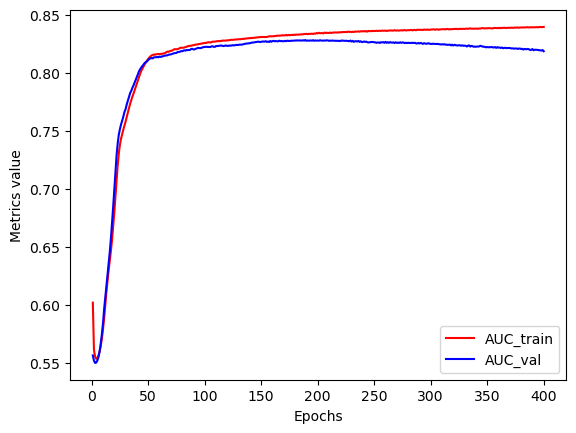

In [623]:
history = model_fit4

keys_list = list(history.history.keys())

loss = history.history[keys_list[0]]
acc = history.history[keys_list[1]]
auc = history.history[keys_list[2]]

val_loss = history.history[keys_list[3]]
val_acc = history.history[keys_list[4]]
val_auc = history.history[keys_list[5]]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, auc, 'r', label='AUC_train')
plt.plot(epochs, val_auc, 'b', label='AUC_val')
plt.xlabel('Epochs')
plt.ylabel('Metrics value')
plt.legend()
plt.show()


results['Model4 (3H - 512-512-512) (Val)'] = np.array([min(val_loss),
                                              max(val_acc),
                                              max(val_auc)])
results['Model4 (3H - 512-512-512) (Train)'] = np.array([min(loss),
                                              max(acc),
                                              max(auc)])


In [624]:
results['Model4 (3H - 512-512-512) (Test)'] = model4.evaluate(X_test, y_test)

420/420 [==============================] - 2s 5ms/step - loss: 0.1999 - accuracy: 0.9330 - auc_95: 0.8197


In [625]:
results [['Model4 (3H - 512-512-512) (Val)','Model4 (3H - 512-512-512) (Train)', 'Model4 (3H - 512-512-512) (Test)']]

,Model4 (3H - 512-512-512) (Val),Model4 (3H - 512-512-512) (Train),Model4 (3H - 512-512-512) (Test)
Loss,0.190825,0.183512,0.199916
Acc,0.936469,0.938657,0.932991
AUC,0.828206,0.839489,0.819685


### Итог: 

Добавление 3-го слоя приводит к некоторому выравниваю показателей. И к увеличению результатов на тестовой выборке, хотя и к снижению на тренировочной.

### IV.5 Пятая модель. Четыре скрытых слоя, 512-512-512-100 нейронов.

In [626]:
model5 = Sequential()

model5.add(Dense(512, activation='relu', input_dim=len(X.columns)))

model5.add(Dense(512, activation='relu'))

model5.add(Dense(512, activation='relu'))

model5.add(Dense(100, activation='relu'))

model5.add(Dense(1, activation='sigmoid', dtype=tf.float64))

model5.compile(optimizer=Adam(0.01), loss='binary_crossentropy', metrics=['accuracy', AUC()])

In [628]:
model_fit5 = model5.fit(X_train, y_train, 
                        batch_size=len(X_train), 
                        validation_data=(X_val, y_val), 
                        epochs=500, 
                        use_multiprocessing=True)
#              callbacks=[stop_early],

Epoch 1/500
1/1 [==============================] - 0s 474ms/step - loss: 0.1828 - accuracy: 0.9393 - auc_96: 0.8401 - val_loss: 0.2004 - val_accuracy: 0.9316 - val_auc_96: 0.8169
Epoch 2/500
1/1 [==============================] - 0s 145ms/step - loss: 0.1826 - accuracy: 0.9394 - auc_96: 0.8407 - val_loss: 0.2001 - val_accuracy: 0.9333 - val_auc_96: 0.8150
Epoch 3/500
1/1 [==============================] - 0s 142ms/step - loss: 0.1825 - accuracy: 0.9390 - auc_96: 0.8417 - val_loss: 0.2005 - val_accuracy: 0.9326 - val_auc_96: 0.8190
Epoch 4/500
1/1 [==============================] - 0s 140ms/step - loss: 0.1820 - accuracy: 0.9393 - auc_96: 0.8412 - val_loss: 0.2019 - val_accuracy: 0.9306 - val_auc_96: 0.8170
Epoch 5/500
1/1 [==============================] - 0s 142ms/step - loss: 0.1823 - accuracy: 0.9389 - auc_96: 0.8414 - val_loss: 0.2034 - val_accuracy: 0.9322 - val_auc_96: 0.8097
Epoch 6/500
1/1 [==============================] - 0s 141ms/step - loss: 0.1824 - accuracy: 0.9386 - auc_

1/1 [==============================] - 0s 144ms/step - loss: 0.1810 - accuracy: 0.9395 - auc_96: 0.8437 - val_loss: 0.2041 - val_accuracy: 0.9317 - val_auc_96: 0.8149
Epoch 47/500
1/1 [==============================] - 0s 142ms/step - loss: 0.1808 - accuracy: 0.9401 - auc_96: 0.8433 - val_loss: 0.2048 - val_accuracy: 0.9326 - val_auc_96: 0.8148
Epoch 48/500
1/1 [==============================] - 0s 142ms/step - loss: 0.1806 - accuracy: 0.9400 - auc_96: 0.8434 - val_loss: 0.2047 - val_accuracy: 0.9323 - val_auc_96: 0.8144
Epoch 49/500
1/1 [==============================] - 0s 142ms/step - loss: 0.1802 - accuracy: 0.9402 - auc_96: 0.8439 - val_loss: 0.2056 - val_accuracy: 0.9313 - val_auc_96: 0.8130
Epoch 50/500
1/1 [==============================] - 0s 147ms/step - loss: 0.1805 - accuracy: 0.9403 - auc_96: 0.8440 - val_loss: 0.2067 - val_accuracy: 0.9322 - val_auc_96: 0.8099
Epoch 51/500
1/1 [==============================] - 0s 152ms/step - loss: 0.1804 - accuracy: 0.9397 - auc_96: 0.8

1/1 [==============================] - 0s 153ms/step - loss: 0.1816 - accuracy: 0.9392 - auc_96: 0.8438 - val_loss: 0.2139 - val_accuracy: 0.9265 - val_auc_96: 0.8111
Epoch 92/500
1/1 [==============================] - 0s 143ms/step - loss: 0.1871 - accuracy: 0.9337 - auc_96: 0.8427 - val_loss: 0.2092 - val_accuracy: 0.9330 - val_auc_96: 0.8091
Epoch 93/500
1/1 [==============================] - 0s 143ms/step - loss: 0.1836 - accuracy: 0.9396 - auc_96: 0.8418 - val_loss: 0.2081 - val_accuracy: 0.9330 - val_auc_96: 0.8026
Epoch 94/500
1/1 [==============================] - 0s 148ms/step - loss: 0.1843 - accuracy: 0.9375 - auc_96: 0.8429 - val_loss: 0.2071 - val_accuracy: 0.9325 - val_auc_96: 0.8035
Epoch 95/500
1/1 [==============================] - 0s 145ms/step - loss: 0.1837 - accuracy: 0.9390 - auc_96: 0.8445 - val_loss: 0.2045 - val_accuracy: 0.9305 - val_auc_96: 0.8139
Epoch 96/500
1/1 [==============================] - 0s 148ms/step - loss: 0.1823 - accuracy: 0.9389 - auc_96: 0.8

1/1 [==============================] - 0s 140ms/step - loss: 0.1800 - accuracy: 0.9404 - auc_96: 0.8475 - val_loss: 0.2187 - val_accuracy: 0.9316 - val_auc_96: 0.7960
Epoch 137/500
1/1 [==============================] - 0s 142ms/step - loss: 0.1800 - accuracy: 0.9401 - auc_96: 0.8454 - val_loss: 0.2161 - val_accuracy: 0.9294 - val_auc_96: 0.8054
Epoch 138/500
1/1 [==============================] - 0s 142ms/step - loss: 0.1792 - accuracy: 0.9404 - auc_96: 0.8452 - val_loss: 0.2141 - val_accuracy: 0.9301 - val_auc_96: 0.8015
Epoch 139/500
1/1 [==============================] - 0s 141ms/step - loss: 0.1791 - accuracy: 0.9407 - auc_96: 0.8465 - val_loss: 0.2143 - val_accuracy: 0.9325 - val_auc_96: 0.7958
Epoch 140/500
1/1 [==============================] - 0s 147ms/step - loss: 0.1791 - accuracy: 0.9407 - auc_96: 0.8458 - val_loss: 0.2162 - val_accuracy: 0.9305 - val_auc_96: 0.8003
Epoch 141/500
1/1 [==============================] - 0s 141ms/step - loss: 0.1783 - accuracy: 0.9410 - auc_96

1/1 [==============================] - 0s 141ms/step - loss: 0.1915 - accuracy: 0.9381 - auc_96: 0.8450 - val_loss: 0.2205 - val_accuracy: 0.9346 - val_auc_96: 0.7990
Epoch 182/500
1/1 [==============================] - 0s 142ms/step - loss: 0.1831 - accuracy: 0.9398 - auc_96: 0.8431 - val_loss: 0.2243 - val_accuracy: 0.9344 - val_auc_96: 0.8019
Epoch 183/500
1/1 [==============================] - 0s 146ms/step - loss: 0.1871 - accuracy: 0.9387 - auc_96: 0.8411 - val_loss: 0.2185 - val_accuracy: 0.9292 - val_auc_96: 0.8030
Epoch 184/500
1/1 [==============================] - 0s 154ms/step - loss: 0.1811 - accuracy: 0.9401 - auc_96: 0.8428 - val_loss: 0.2200 - val_accuracy: 0.9294 - val_auc_96: 0.7980
Epoch 185/500
1/1 [==============================] - 0s 142ms/step - loss: 0.1849 - accuracy: 0.9398 - auc_96: 0.8434 - val_loss: 0.2170 - val_accuracy: 0.9336 - val_auc_96: 0.7938
Epoch 186/500
1/1 [==============================] - 0s 141ms/step - loss: 0.1820 - accuracy: 0.9399 - auc_96

1/1 [==============================] - 0s 142ms/step - loss: 0.1775 - accuracy: 0.9414 - auc_96: 0.8473 - val_loss: 0.2216 - val_accuracy: 0.9312 - val_auc_96: 0.7984
Epoch 227/500
1/1 [==============================] - 0s 142ms/step - loss: 0.1778 - accuracy: 0.9415 - auc_96: 0.8475 - val_loss: 0.2230 - val_accuracy: 0.9307 - val_auc_96: 0.7874
Epoch 228/500
1/1 [==============================] - 0s 155ms/step - loss: 0.1775 - accuracy: 0.9411 - auc_96: 0.8484 - val_loss: 0.2247 - val_accuracy: 0.9294 - val_auc_96: 0.7911
Epoch 229/500
1/1 [==============================] - 0s 146ms/step - loss: 0.1767 - accuracy: 0.9420 - auc_96: 0.8497 - val_loss: 0.2249 - val_accuracy: 0.9308 - val_auc_96: 0.7955
Epoch 230/500
1/1 [==============================] - 0s 145ms/step - loss: 0.1765 - accuracy: 0.9420 - auc_96: 0.8495 - val_loss: 0.2247 - val_accuracy: 0.9310 - val_auc_96: 0.7917
Epoch 231/500
1/1 [==============================] - 0s 141ms/step - loss: 0.1763 - accuracy: 0.9422 - auc_96

1/1 [==============================] - 0s 144ms/step - loss: 0.1751 - accuracy: 0.9428 - auc_96: 0.8516 - val_loss: 0.2408 - val_accuracy: 0.9306 - val_auc_96: 0.7785
Epoch 272/500
1/1 [==============================] - 0s 148ms/step - loss: 0.1744 - accuracy: 0.9430 - auc_96: 0.8528 - val_loss: 0.2416 - val_accuracy: 0.9285 - val_auc_96: 0.7739
Epoch 273/500
1/1 [==============================] - 0s 144ms/step - loss: 0.1737 - accuracy: 0.9431 - auc_96: 0.8522 - val_loss: 0.2433 - val_accuracy: 0.9278 - val_auc_96: 0.7651
Epoch 274/500
1/1 [==============================] - 0s 144ms/step - loss: 0.1735 - accuracy: 0.9433 - auc_96: 0.8538 - val_loss: 0.2432 - val_accuracy: 0.9289 - val_auc_96: 0.7834
Epoch 275/500
1/1 [==============================] - 0s 144ms/step - loss: 0.1736 - accuracy: 0.9436 - auc_96: 0.8527 - val_loss: 0.2435 - val_accuracy: 0.9280 - val_auc_96: 0.7779
Epoch 276/500
1/1 [==============================] - 0s 148ms/step - loss: 0.1729 - accuracy: 0.9440 - auc_96

1/1 [==============================] - 0s 144ms/step - loss: 0.1783 - accuracy: 0.9409 - auc_96: 0.8472 - val_loss: 0.2232 - val_accuracy: 0.9312 - val_auc_96: 0.7972
Epoch 317/500
1/1 [==============================] - 0s 141ms/step - loss: 0.1779 - accuracy: 0.9410 - auc_96: 0.8477 - val_loss: 0.2249 - val_accuracy: 0.9305 - val_auc_96: 0.7911
Epoch 318/500
1/1 [==============================] - 0s 146ms/step - loss: 0.1775 - accuracy: 0.9409 - auc_96: 0.8488 - val_loss: 0.2255 - val_accuracy: 0.9306 - val_auc_96: 0.7891
Epoch 319/500
1/1 [==============================] - 0s 141ms/step - loss: 0.1771 - accuracy: 0.9409 - auc_96: 0.8489 - val_loss: 0.2254 - val_accuracy: 0.9307 - val_auc_96: 0.7903
Epoch 320/500
1/1 [==============================] - 0s 143ms/step - loss: 0.1768 - accuracy: 0.9411 - auc_96: 0.8494 - val_loss: 0.2251 - val_accuracy: 0.9295 - val_auc_96: 0.7898
Epoch 321/500
1/1 [==============================] - 0s 141ms/step - loss: 0.1764 - accuracy: 0.9415 - auc_96

1/1 [==============================] - 0s 143ms/step - loss: 0.1721 - accuracy: 0.9435 - auc_96: 0.8551 - val_loss: 0.2504 - val_accuracy: 0.9279 - val_auc_96: 0.7731
Epoch 362/500
1/1 [==============================] - 0s 143ms/step - loss: 0.1722 - accuracy: 0.9438 - auc_96: 0.8544 - val_loss: 0.2514 - val_accuracy: 0.9264 - val_auc_96: 0.7670
Epoch 363/500
1/1 [==============================] - 0s 142ms/step - loss: 0.1718 - accuracy: 0.9442 - auc_96: 0.8550 - val_loss: 0.2487 - val_accuracy: 0.9277 - val_auc_96: 0.7652
Epoch 364/500
1/1 [==============================] - 0s 145ms/step - loss: 0.1717 - accuracy: 0.9439 - auc_96: 0.8556 - val_loss: 0.2484 - val_accuracy: 0.9281 - val_auc_96: 0.7710
Epoch 365/500
1/1 [==============================] - 0s 141ms/step - loss: 0.1713 - accuracy: 0.9440 - auc_96: 0.8557 - val_loss: 0.2536 - val_accuracy: 0.9279 - val_auc_96: 0.7625
Epoch 366/500
1/1 [==============================] - 0s 140ms/step - loss: 0.1707 - accuracy: 0.9439 - auc_96

1/1 [==============================] - 0s 145ms/step - loss: 0.1717 - accuracy: 0.9436 - auc_96: 0.8571 - val_loss: 0.2777 - val_accuracy: 0.9317 - val_auc_96: 0.7096
Epoch 407/500
1/1 [==============================] - 0s 142ms/step - loss: 0.1747 - accuracy: 0.9420 - auc_96: 0.8561 - val_loss: 0.2672 - val_accuracy: 0.9292 - val_auc_96: 0.7567
Epoch 408/500
1/1 [==============================] - 0s 141ms/step - loss: 0.1731 - accuracy: 0.9428 - auc_96: 0.8561 - val_loss: 0.2651 - val_accuracy: 0.9298 - val_auc_96: 0.7625
Epoch 409/500
1/1 [==============================] - 0s 145ms/step - loss: 0.1712 - accuracy: 0.9440 - auc_96: 0.8563 - val_loss: 0.2731 - val_accuracy: 0.9279 - val_auc_96: 0.7388
Epoch 410/500
1/1 [==============================] - 0s 151ms/step - loss: 0.1718 - accuracy: 0.9433 - auc_96: 0.8560 - val_loss: 0.2757 - val_accuracy: 0.9259 - val_auc_96: 0.7443
Epoch 411/500
1/1 [==============================] - 0s 144ms/step - loss: 0.1708 - accuracy: 0.9446 - auc_96

1/1 [==============================] - 0s 140ms/step - loss: 0.1670 - accuracy: 0.9463 - auc_96: 0.8627 - val_loss: 0.3099 - val_accuracy: 0.9301 - val_auc_96: 0.7097
Epoch 452/500
1/1 [==============================] - 0s 148ms/step - loss: 0.1689 - accuracy: 0.9442 - auc_96: 0.8641 - val_loss: 0.3346 - val_accuracy: 0.9146 - val_auc_96: 0.7256
Epoch 453/500
1/1 [==============================] - 0s 146ms/step - loss: 0.1727 - accuracy: 0.9435 - auc_96: 0.8613 - val_loss: 0.3259 - val_accuracy: 0.9327 - val_auc_96: 0.7188
Epoch 454/500
1/1 [==============================] - 0s 146ms/step - loss: 0.1869 - accuracy: 0.9415 - auc_96: 0.8541 - val_loss: 0.2972 - val_accuracy: 0.9287 - val_auc_96: 0.7429
Epoch 455/500
1/1 [==============================] - 0s 144ms/step - loss: 0.1733 - accuracy: 0.9428 - auc_96: 0.8528 - val_loss: 0.2899 - val_accuracy: 0.9280 - val_auc_96: 0.7227
Epoch 456/500
1/1 [==============================] - 0s 144ms/step - loss: 0.1747 - accuracy: 0.9449 - auc_96

1/1 [==============================] - 0s 147ms/step - loss: 0.1735 - accuracy: 0.9423 - auc_96: 0.8553 - val_loss: 0.2881 - val_accuracy: 0.9256 - val_auc_96: 0.7642
Epoch 497/500
1/1 [==============================] - 0s 147ms/step - loss: 0.1752 - accuracy: 0.9418 - auc_96: 0.8539 - val_loss: 0.2819 - val_accuracy: 0.9269 - val_auc_96: 0.7649
Epoch 498/500
1/1 [==============================] - 0s 148ms/step - loss: 0.1744 - accuracy: 0.9422 - auc_96: 0.8553 - val_loss: 0.2726 - val_accuracy: 0.9295 - val_auc_96: 0.7456
Epoch 499/500
1/1 [==============================] - 0s 149ms/step - loss: 0.1732 - accuracy: 0.9428 - auc_96: 0.8554 - val_loss: 0.2684 - val_accuracy: 0.9310 - val_auc_96: 0.7408
Epoch 500/500
1/1 [==============================] - 0s 142ms/step - loss: 0.1733 - accuracy: 0.9422 - auc_96: 0.8571 - val_loss: 0.2684 - val_accuracy: 0.9305 - val_auc_96: 0.7543


In [629]:
results['Model5 (4H - 512-512-512-512) (Test)'] = model5.evaluate(X_test, y_test)

420/420 [==============================] - 2s 5ms/step - loss: 0.4527 - accuracy: 0.9209 - auc_96: 0.7271


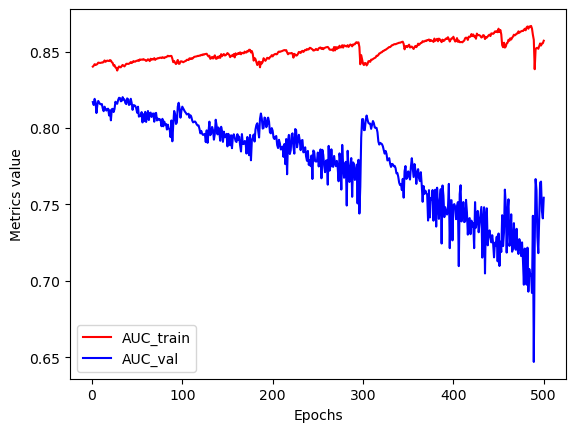

In [630]:
history = model_fit5

keys_list = list(history.history.keys())

loss = history.history[keys_list[0]]
acc = history.history[keys_list[1]]
auc = history.history[keys_list[2]]

val_loss = history.history[keys_list[3]]
val_acc = history.history[keys_list[4]]
val_auc = history.history[keys_list[5]]



epochs = range(1, len(acc) + 1)
plt.plot(epochs, auc, 'r', label='AUC_train')
plt.plot(epochs, val_auc, 'b', label='AUC_val')
plt.xlabel('Epochs')
plt.ylabel('Metrics value')
plt.legend()
plt.show()


results['Model5 (4H - 512-512-512-512) (Val)'] = np.array([min(val_loss),
                                              max(val_acc),
                                              max(val_auc)])
results['Model5 (4H - 512-512-512-512) (Train)'] = np.array([min(loss),
                                              max(acc),
                                              max(auc)])

In [631]:
results[['Model5 (4H - 512-512-512-512) (Test)','Model5 (4H - 512-512-512-512) (Train)','Model5 (4H - 512-512-512-512) (Val)']]

,Model5 (4H - 512-512-512-512) (Test),Model5 (4H - 512-512-512-512) (Train),Model5 (4H - 512-512-512-512) (Val)
Loss,0.452663,0.163291,0.198484
Acc,0.920929,0.947780,0.934937
AUC,0.727059,0.866738,0.820159


### Итог: 

Дальнейшее усложнение сети вновь приводит к падению результатов на тестовом наборе, дальнейшему росту на тренировочном и отсутствию изменений со стороны валидационного сета.

### IV.6 Шестая модель. Проба свертки с двумя входами

In [697]:
input_ = tf.keras.layers.Input(shape=X_train.shape[1:])

hidden1 = tf.keras.layers.Dense(500, activation="relu")(input_)
hidden1B = tf.keras.layers.Dense(500, activation="relu")(input_)

hidden2 = tf.keras.layers.Dense(500, activation="relu")(hidden1)
hidden3 = tf.keras.layers.Dense(500, activation="relu")(hidden2)

concat = tf.keras.layers.concatenate([hidden1B, hidden3])

output = tf.keras.layers.Dense(1, activation='sigmoid')(concat)

model = tf.keras.models.Model(inputs=[input_], outputs=[output])

In [698]:
model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=['accuracy', AUC()])
history = model.fit(X_train, y_train, batch_size=1024,
                    epochs=20,
                    validation_data=(X_val, y_val))

Epoch 1/20
103/103 [==============================] - 2s 14ms/step - loss: 0.2356 - accuracy: 0.9284 - auc_116: 0.7323 - val_loss: 0.1950 - val_accuracy: 0.9367 - val_auc_116: 0.8159
Epoch 2/20
103/103 [==============================] - 1s 9ms/step - loss: 0.1919 - accuracy: 0.9362 - auc_116: 0.8153 - val_loss: 0.1921 - val_accuracy: 0.9358 - val_auc_116: 0.8213
Epoch 3/20
103/103 [==============================] - 1s 9ms/step - loss: 0.1905 - accuracy: 0.9364 - auc_116: 0.8202 - val_loss: 0.1980 - val_accuracy: 0.9352 - val_auc_116: 0.8213
Epoch 4/20
103/103 [==============================] - 1s 10ms/step - loss: 0.1911 - accuracy: 0.9366 - auc_116: 0.8170 - val_loss: 0.1929 - val_accuracy: 0.9355 - val_auc_116: 0.8238
Epoch 5/20
103/103 [==============================] - 1s 10ms/step - loss: 0.1892 - accuracy: 0.9366 - auc_116: 0.8244 - val_loss: 0.1918 - val_accuracy: 0.9358 - val_auc_116: 0.8255
Epoch 6/20
103/103 [==============================] - 1s 9ms/step - loss: 0.1891 - accu

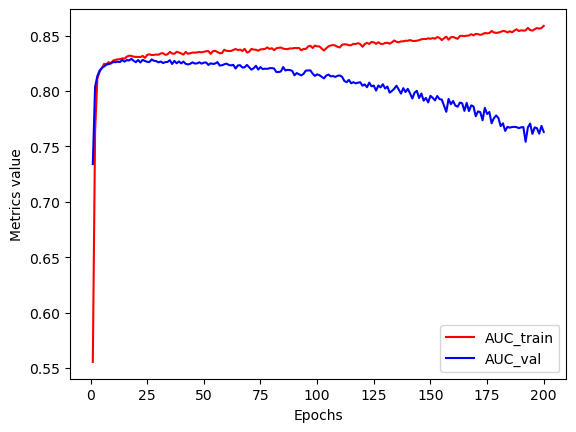

In [635]:
keys_list = list(history.history.keys())

loss = history.history[keys_list[0]]
acc = history.history[keys_list[1]]
auc = history.history[keys_list[2]]

val_loss = history.history[keys_list[3]]
val_acc = history.history[keys_list[4]]
val_auc = history.history[keys_list[5]]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, auc, 'r', label='AUC_train')
plt.plot(epochs, val_auc, 'b', label='AUC_val')
plt.xlabel('Epochs')
plt.ylabel('Metrics value')
plt.legend()
plt.show()


results['Model6 Conv (Val)'] = np.array([min(val_loss),
                                              max(val_acc),
                                              max(val_auc)])
results['Model6 Conv (Train)'] = np.array([min(loss),
                                              max(acc),
                                              max(auc)])

In [636]:
results['Model6 Conv (Test)'] = model.evaluate(X_test, y_test)

420/420 [==============================] - 2s 5ms/step - loss: 0.3924 - accuracy: 0.8997 - auc_98: 0.7187


In [638]:
results[['Model6 Conv (Test)', 'Model6 Conv (Train)', 'Model6 Conv (Val)']]

,Model6 Conv (Test),Model6 Conv (Train),Model6 Conv (Val)
Loss,0.392395,0.166661,0.190353
Acc,0.899710,0.947205,0.936214
AUC,0.718707,0.858849,0.829162


### Итог: 

В случае со сверточными видим некоторое увеличение на валидационном сете.

### V. Подбор параметров (на примере модели 6)

#### Подбираем размер бэтча

In [704]:
batches = [128,256,512,1024,2048,4096]

In [705]:
results_batch_train = pd.DataFrame(index=['Loss', 'Acc', 'AUC'])
results_batch_test = pd.DataFrame(index=['Loss', 'Acc', 'AUC'])
results_batch_val = pd.DataFrame(index=['Loss', 'Acc', 'AUC'])

In [706]:
for i in batches:
    input_ = tf.keras.layers.Input(shape=X_train.shape[1:])

    hidden1 = tf.keras.layers.Dense(500, activation="relu")(input_)
    hidden1B = tf.keras.layers.Dense(500, activation="relu")(input_)

    hidden2 = tf.keras.layers.Dense(500, activation="relu")(hidden1)
    hidden3 = tf.keras.layers.Dense(500, activation="relu")(hidden2)

    concat = tf.keras.layers.concatenate([hidden1B, hidden3])

    output = tf.keras.layers.Dense(1, activation='sigmoid')(concat)

    model = tf.keras.models.Model(inputs=[input_], outputs=[output])
    
    model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=['accuracy', AUC()])
    history = model.fit(X_train, y_train, batch_size=int(i),
                    epochs=20,
                    validation_data=(X_val, y_val))
    
    keys_list = list(history.history.keys())
    loss = history.history[keys_list[0]]
    acc = history.history[keys_list[1]]
    auc = history.history[keys_list[2]]
    val_loss = history.history[keys_list[3]]
    val_acc = history.history[keys_list[4]]
    val_auc = history.history[keys_list[5]]
    
  
    results_batch_val [str(int(i))] = np.array([min(val_loss),
                                              max(val_acc),
                                              max(val_auc)])
    results_batch_train[str(int(i))] = np.array([min(loss),
                          max(acc),
                          max(auc)])
    results_batch_test[str(int(i))] = model.evaluate(X_test, y_test)

Epoch 1/20
817/817 [==============================] - 10s 9ms/step - loss: 0.1987 - accuracy: 0.9354 - auc_126: 0.8012 - val_loss: 0.1958 - val_accuracy: 0.9355 - val_auc_126: 0.8200
Epoch 2/20
817/817 [==============================] - 8s 9ms/step - loss: 0.1913 - accuracy: 0.9361 - auc_126: 0.8177 - val_loss: 0.1937 - val_accuracy: 0.9357 - val_auc_126: 0.8239
Epoch 3/20
817/817 [==============================] - 8s 10ms/step - loss: 0.1901 - accuracy: 0.9365 - auc_126: 0.8215 - val_loss: 0.1917 - val_accuracy: 0.9360 - val_auc_126: 0.8253
Epoch 4/20
817/817 [==============================] - 8s 10ms/step - loss: 0.1894 - accuracy: 0.9368 - auc_126: 0.8243 - val_loss: 0.1905 - val_accuracy: 0.9360 - val_auc_126: 0.8266
Epoch 5/20
817/817 [==============================] - 7s 8ms/step - loss: 0.1891 - accuracy: 0.9364 - auc_126: 0.8257 - val_loss: 0.1905 - val_accuracy: 0.9367 - val_auc_126: 0.8292
Epoch 6/20
817/817 [==============================] - 7s 9ms/step - loss: 0.1888 - accu

205/205 [==============================] - 2s 10ms/step - loss: 0.1895 - accuracy: 0.9363 - auc_128: 0.8240 - val_loss: 0.1918 - val_accuracy: 0.9359 - val_auc_128: 0.8255
Epoch 5/20
205/205 [==============================] - 2s 9ms/step - loss: 0.1890 - accuracy: 0.9365 - auc_128: 0.8257 - val_loss: 0.1943 - val_accuracy: 0.9360 - val_auc_128: 0.8239
Epoch 6/20
205/205 [==============================] - 2s 10ms/step - loss: 0.1892 - accuracy: 0.9365 - auc_128: 0.8263 - val_loss: 0.1907 - val_accuracy: 0.9360 - val_auc_128: 0.8276
Epoch 7/20
205/205 [==============================] - 2s 10ms/step - loss: 0.1882 - accuracy: 0.9365 - auc_128: 0.8289 - val_loss: 0.1927 - val_accuracy: 0.9363 - val_auc_128: 0.8283
Epoch 8/20
205/205 [==============================] - 2s 9ms/step - loss: 0.1881 - accuracy: 0.9367 - auc_128: 0.8292 - val_loss: 0.1907 - val_accuracy: 0.9362 - val_auc_128: 0.8285
Epoch 9/20
205/205 [==============================] - 2s 9ms/step - loss: 0.1892 - accuracy: 0.936

Epoch 8/20
52/52 [==============================] - 1s 11ms/step - loss: 0.1896 - accuracy: 0.9365 - auc_130: 0.8242 - val_loss: 0.1929 - val_accuracy: 0.9360 - val_auc_130: 0.8247
Epoch 9/20
52/52 [==============================] - 1s 10ms/step - loss: 0.1894 - accuracy: 0.9365 - auc_130: 0.8242 - val_loss: 0.1936 - val_accuracy: 0.9361 - val_auc_130: 0.8254
Epoch 10/20
52/52 [==============================] - 1s 10ms/step - loss: 0.1894 - accuracy: 0.9366 - auc_130: 0.8237 - val_loss: 0.1915 - val_accuracy: 0.9362 - val_auc_130: 0.8260
Epoch 11/20
52/52 [==============================] - 1s 10ms/step - loss: 0.1887 - accuracy: 0.9365 - auc_130: 0.8257 - val_loss: 0.1933 - val_accuracy: 0.9362 - val_auc_130: 0.8266
Epoch 12/20
52/52 [==============================] - 0s 9ms/step - loss: 0.1889 - accuracy: 0.9367 - auc_130: 0.8258 - val_loss: 0.1906 - val_accuracy: 0.9359 - val_auc_130: 0.8275
Epoch 13/20
52/52 [==============================] - 1s 11ms/step - loss: 0.1886 - accuracy: 

In [725]:
results_batch_val.loc[['AUC']]

,128,256,512,1024,2048,4096
AUC,0.829563,0.82995,0.83031,0.829199,0.829686,0.82779


<AxesSubplot: ylabel='AUC'>

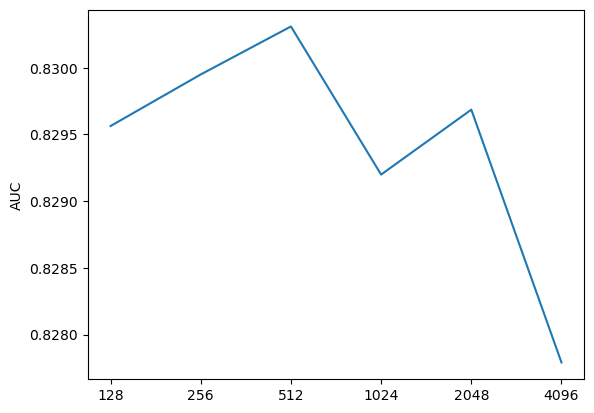

In [724]:
sns.lineplot (x=results_batch_val.columns, y=results_batch_val.loc['AUC'])

In [715]:
results_batch_train.loc[['AUC']]

,128,256,512,1024,2048,4096
AUC,0.832968,0.831543,0.831196,0.83155,0.831136,0.831147


<AxesSubplot: ylabel='AUC'>

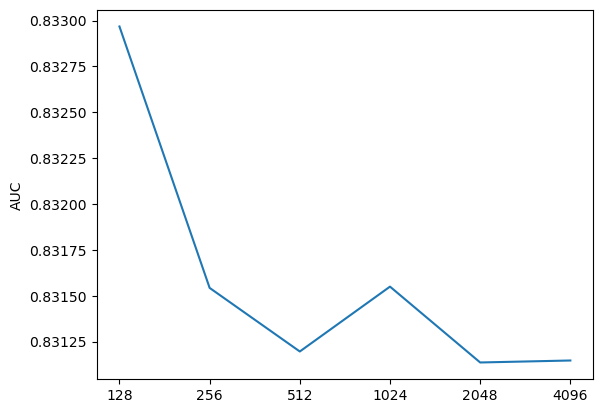

In [726]:
sns.lineplot (x=results_batch_train.columns, y=results_batch_train.loc['AUC'])

In [716]:
results_batch_test.loc[['AUC']]

,128,256,512,1024,2048,4096
AUC,0.819051,0.824593,0.828485,0.827548,0.828161,0.827672


<AxesSubplot: ylabel='AUC'>

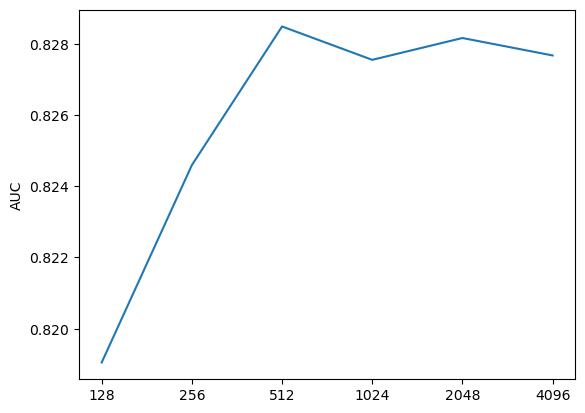

In [727]:
sns.lineplot (x=results_batch_test.columns, y=results_batch_test.loc['AUC'])

#### Поиграем со скоростью обучения

In [728]:
results_speed_train = pd.DataFrame(index=['Loss', 'Acc', 'AUC'])
results_speed_test = pd.DataFrame(index=['Loss', 'Acc', 'AUC'])
results_speed_val = pd.DataFrame(index=['Loss', 'Acc', 'AUC'])

In [729]:
speed = [0.1,0.01,0.001,0.0001]

In [732]:
for i in speed:
    input_ = tf.keras.layers.Input(shape=X_train.shape[1:])

    hidden1 = tf.keras.layers.Dense(500, activation="relu")(input_)
    hidden1B = tf.keras.layers.Dense(500, activation="relu")(input_)

    hidden2 = tf.keras.layers.Dense(500, activation="relu")(hidden1)
    hidden3 = tf.keras.layers.Dense(500, activation="relu")(hidden2)

    concat = tf.keras.layers.concatenate([hidden1B, hidden3])

    output = tf.keras.layers.Dense(1, activation='sigmoid')(concat)

    model = tf.keras.models.Model(inputs=[input_], outputs=[output])
    
    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=i), metrics=['accuracy', AUC()])
    history = model.fit(X_train, y_train, batch_size=4096,
                    epochs=20,
                    validation_data=(X_val, y_val))
    
    keys_list = list(history.history.keys())
    loss = history.history[keys_list[0]]
    acc = history.history[keys_list[1]]
    auc = history.history[keys_list[2]]
    val_loss = history.history[keys_list[3]]
    val_acc = history.history[keys_list[4]]
    val_auc = history.history[keys_list[5]]
    
    results_speed_val [str(i)] = np.array([min(val_loss),
                                              max(val_acc),
                                              max(val_auc)])
    results_speed_train[str(i)] = np.array([min(loss),
                          max(acc),
                          max(auc)])
    results_speed_test[str(i)] = model.evaluate(X_test, y_test)

Epoch 1/20
26/26 [==============================] - 2s 31ms/step - loss: 3.9145 - accuracy: 0.9020 - auc_136: 0.6532 - val_loss: 0.2650 - val_accuracy: 0.9350 - val_auc_136: 0.7694
Epoch 2/20
26/26 [==============================] - 0s 11ms/step - loss: 0.2194 - accuracy: 0.9339 - auc_136: 0.7514 - val_loss: 0.1980 - val_accuracy: 0.9367 - val_auc_136: 0.8072
Epoch 3/20
26/26 [==============================] - 0s 11ms/step - loss: 0.1930 - accuracy: 0.9360 - auc_136: 0.8137 - val_loss: 0.1943 - val_accuracy: 0.9360 - val_auc_136: 0.8181
Epoch 4/20
26/26 [==============================] - 0s 11ms/step - loss: 0.1922 - accuracy: 0.9361 - auc_136: 0.8165 - val_loss: 0.1928 - val_accuracy: 0.9352 - val_auc_136: 0.8195
Epoch 5/20
26/26 [==============================] - 0s 11ms/step - loss: 0.1905 - accuracy: 0.9366 - auc_136: 0.8216 - val_loss: 0.1925 - val_accuracy: 0.9357 - val_auc_136: 0.8205
Epoch 6/20
26/26 [==============================] - 0s 11ms/step - loss: 0.1912 - accuracy: 0.9

Epoch 5/20
26/26 [==============================] - 0s 11ms/step - loss: 0.1906 - accuracy: 0.9363 - auc_138: 0.8216 - val_loss: 0.1925 - val_accuracy: 0.9357 - val_auc_138: 0.8212
Epoch 6/20
26/26 [==============================] - 0s 11ms/step - loss: 0.1895 - accuracy: 0.9365 - auc_138: 0.8244 - val_loss: 0.1919 - val_accuracy: 0.9354 - val_auc_138: 0.8225
Epoch 7/20
26/26 [==============================] - 0s 11ms/step - loss: 0.1891 - accuracy: 0.9362 - auc_138: 0.8257 - val_loss: 0.1919 - val_accuracy: 0.9354 - val_auc_138: 0.8238
Epoch 8/20
26/26 [==============================] - 0s 11ms/step - loss: 0.1891 - accuracy: 0.9366 - auc_138: 0.8250 - val_loss: 0.1914 - val_accuracy: 0.9355 - val_auc_138: 0.8243
Epoch 9/20
26/26 [==============================] - 0s 11ms/step - loss: 0.1889 - accuracy: 0.9365 - auc_138: 0.8258 - val_loss: 0.1931 - val_accuracy: 0.9361 - val_auc_138: 0.8233
Epoch 10/20
26/26 [==============================] - 0s 11ms/step - loss: 0.1888 - accuracy: 0.

In [733]:
results_speed_val.loc[['AUC']]

,0,0.1,0.01,0.001,0.0001
AUC,0.821128,0.821463,0.828946,0.829197,0.821474


<AxesSubplot: ylabel='AUC'>

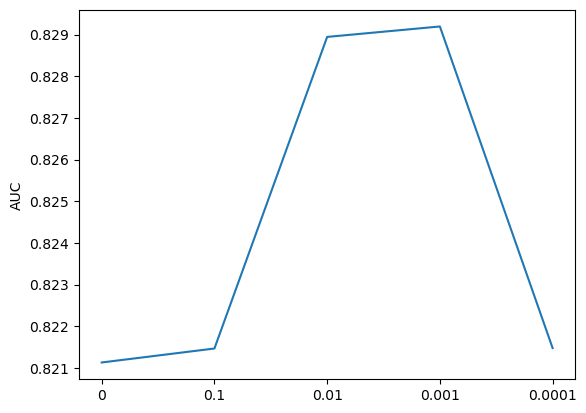

In [734]:
sns.lineplot (x=results_speed_val.columns, y=results_speed_val.loc['AUC'])

In [735]:
results_speed_train.loc[['AUC']]

,0,0.1,0.01,0.001,0.0001
AUC,0.82389,0.823228,0.832736,0.832182,0.824343


<AxesSubplot: ylabel='AUC'>

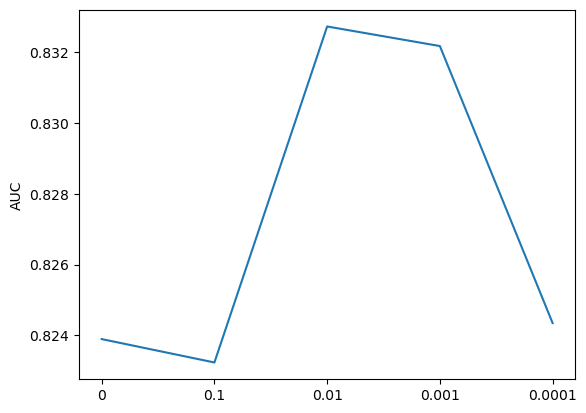

In [736]:
sns.lineplot (x=results_speed_train.columns, y=results_speed_train.loc['AUC'])

In [737]:
results_speed_test.loc[['AUC']]

,0,0.1,0.01,0.001,0.0001
AUC,0.826232,0.819184,0.82515,0.82631,0.825094


<AxesSubplot: ylabel='AUC'>

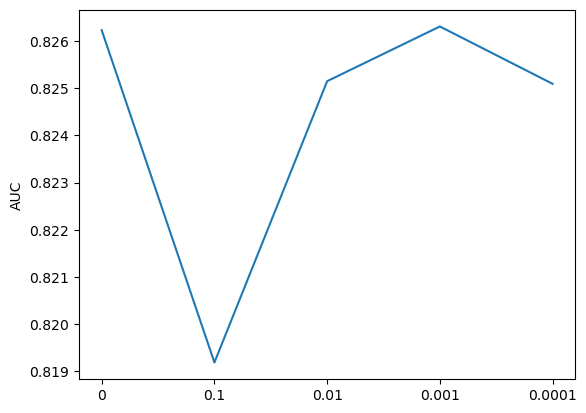

In [738]:
sns.lineplot (x=results_speed_test.columns, y=results_speed_test.loc['AUC'])

#### Поиграем с количеством эпох

In [739]:
epo = [20,40,60,120,240,500]

In [740]:
results_epo_train = pd.DataFrame(index=['Loss', 'Acc', 'AUC'])
results_epo_test = pd.DataFrame(index=['Loss', 'Acc', 'AUC'])
results_epo_val = pd.DataFrame(index=['Loss', 'Acc', 'AUC'])

In [742]:
for i in epo:
    input_ = tf.keras.layers.Input(shape=X_train.shape[1:])

    hidden1 = tf.keras.layers.Dense(500, activation="relu")(input_)
    hidden1B = tf.keras.layers.Dense(500, activation="relu")(input_)

    hidden2 = tf.keras.layers.Dense(500, activation="relu")(hidden1)
    hidden3 = tf.keras.layers.Dense(500, activation="relu")(hidden2)

    concat = tf.keras.layers.concatenate([hidden1B, hidden3])

    output = tf.keras.layers.Dense(1, activation='sigmoid')(concat)
    
    model = tf.keras.models.Model(inputs=[input_], outputs=[output])
   
    model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=['accuracy', AUC()])
    history = model.fit(X_train, y_train, batch_size=4096,
                    epochs=i,
                    validation_data=(X_val, y_val))
    
    keys_list = list(history.history.keys())
    loss = history.history[keys_list[0]]
    acc = history.history[keys_list[1]]
    auc = history.history[keys_list[2]]
    val_loss = history.history[keys_list[3]]
    val_acc = history.history[keys_list[4]]
    val_auc = history.history[keys_list[5]]
    
    results_epo_val [str(int(i))] = np.array([min(val_loss),
                                              max(val_acc),
                                              max(val_auc)])
    results_epo_train[str(int(i))] = np.array([min(loss),
                          max(acc),
                          max(auc)])
    results_epo_test[str(int(i))] = model.evaluate(X_test, y_test)

Epoch 1/20
26/26 [==============================] - 2s 29ms/step - loss: 0.3333 - accuracy: 0.9330 - auc_141: 0.5553 - val_loss: 0.2315 - val_accuracy: 0.9324 - val_auc_141: 0.7431
Epoch 2/20
26/26 [==============================] - 0s 13ms/step - loss: 0.2091 - accuracy: 0.9344 - auc_141: 0.7696 - val_loss: 0.1975 - val_accuracy: 0.9355 - val_auc_141: 0.8047
Epoch 3/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1947 - accuracy: 0.9352 - auc_141: 0.8105 - val_loss: 0.1965 - val_accuracy: 0.9365 - val_auc_141: 0.8115
Epoch 4/20
26/26 [==============================] - 0s 13ms/step - loss: 0.1922 - accuracy: 0.9363 - auc_141: 0.8174 - val_loss: 0.1932 - val_accuracy: 0.9358 - val_auc_141: 0.8180
Epoch 5/20
26/26 [==============================] - 0s 13ms/step - loss: 0.1904 - accuracy: 0.9364 - auc_141: 0.8224 - val_loss: 0.1927 - val_accuracy: 0.9354 - val_auc_141: 0.8204
Epoch 6/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1900 - accuracy: 0.9

26/26 [==============================] - 0s 12ms/step - loss: 0.1870 - accuracy: 0.9367 - auc_142: 0.8333 - val_loss: 0.1912 - val_accuracy: 0.9354 - val_auc_142: 0.8277
Epoch 26/40
26/26 [==============================] - 0s 11ms/step - loss: 0.1870 - accuracy: 0.9368 - auc_142: 0.8334 - val_loss: 0.1921 - val_accuracy: 0.9360 - val_auc_142: 0.8277
Epoch 27/40
26/26 [==============================] - 0s 12ms/step - loss: 0.1873 - accuracy: 0.9366 - auc_142: 0.8320 - val_loss: 0.1931 - val_accuracy: 0.9360 - val_auc_142: 0.8268
Epoch 28/40
26/26 [==============================] - 0s 12ms/step - loss: 0.1866 - accuracy: 0.9369 - auc_142: 0.8337 - val_loss: 0.1905 - val_accuracy: 0.9359 - val_auc_142: 0.8282
Epoch 29/40
26/26 [==============================] - 0s 12ms/step - loss: 0.1866 - accuracy: 0.9368 - auc_142: 0.8342 - val_loss: 0.1917 - val_accuracy: 0.9361 - val_auc_142: 0.8283
Epoch 30/40
26/26 [==============================] - 0s 12ms/step - loss: 0.1867 - accuracy: 0.9369 - 

26/26 [==============================] - 0s 12ms/step - loss: 0.1869 - accuracy: 0.9369 - auc_143: 0.8332 - val_loss: 0.1915 - val_accuracy: 0.9361 - val_auc_143: 0.8269
Epoch 30/60
26/26 [==============================] - 0s 12ms/step - loss: 0.1865 - accuracy: 0.9371 - auc_143: 0.8339 - val_loss: 0.1911 - val_accuracy: 0.9363 - val_auc_143: 0.8274
Epoch 31/60
26/26 [==============================] - 0s 12ms/step - loss: 0.1864 - accuracy: 0.9370 - auc_143: 0.8342 - val_loss: 0.1920 - val_accuracy: 0.9362 - val_auc_143: 0.8267
Epoch 32/60
26/26 [==============================] - 0s 12ms/step - loss: 0.1865 - accuracy: 0.9371 - auc_143: 0.8337 - val_loss: 0.1921 - val_accuracy: 0.9361 - val_auc_143: 0.8263
Epoch 33/60
26/26 [==============================] - 0s 11ms/step - loss: 0.1866 - accuracy: 0.9370 - auc_143: 0.8334 - val_loss: 0.1920 - val_accuracy: 0.9362 - val_auc_143: 0.8268
Epoch 34/60
26/26 [==============================] - 0s 12ms/step - loss: 0.1862 - accuracy: 0.9370 - 

26/26 [==============================] - 0s 12ms/step - loss: 0.1881 - accuracy: 0.9365 - auc_144: 0.8291 - val_loss: 0.1910 - val_accuracy: 0.9360 - val_auc_144: 0.8274
Epoch 14/120
26/26 [==============================] - 0s 12ms/step - loss: 0.1881 - accuracy: 0.9368 - auc_144: 0.8290 - val_loss: 0.1914 - val_accuracy: 0.9357 - val_auc_144: 0.8260
Epoch 15/120
26/26 [==============================] - 0s 12ms/step - loss: 0.1881 - accuracy: 0.9367 - auc_144: 0.8290 - val_loss: 0.1909 - val_accuracy: 0.9366 - val_auc_144: 0.8276
Epoch 16/120
26/26 [==============================] - 0s 12ms/step - loss: 0.1883 - accuracy: 0.9365 - auc_144: 0.8288 - val_loss: 0.1903 - val_accuracy: 0.9361 - val_auc_144: 0.8283
Epoch 17/120
26/26 [==============================] - 0s 12ms/step - loss: 0.1876 - accuracy: 0.9368 - auc_144: 0.8308 - val_loss: 0.1923 - val_accuracy: 0.9361 - val_auc_144: 0.8286
Epoch 18/120
26/26 [==============================] - 0s 12ms/step - loss: 0.1877 - accuracy: 0.93

Epoch 58/120
26/26 [==============================] - 0s 12ms/step - loss: 0.1852 - accuracy: 0.9378 - auc_144: 0.8362 - val_loss: 0.1944 - val_accuracy: 0.9362 - val_auc_144: 0.8231
Epoch 59/120
26/26 [==============================] - 0s 12ms/step - loss: 0.1856 - accuracy: 0.9377 - auc_144: 0.8345 - val_loss: 0.1959 - val_accuracy: 0.9361 - val_auc_144: 0.8222
Epoch 60/120
26/26 [==============================] - 0s 11ms/step - loss: 0.1854 - accuracy: 0.9375 - auc_144: 0.8357 - val_loss: 0.1937 - val_accuracy: 0.9352 - val_auc_144: 0.8236
Epoch 61/120
26/26 [==============================] - 0s 12ms/step - loss: 0.1860 - accuracy: 0.9377 - auc_144: 0.8337 - val_loss: 0.1943 - val_accuracy: 0.9364 - val_auc_144: 0.8228
Epoch 62/120
26/26 [==============================] - 0s 11ms/step - loss: 0.1856 - accuracy: 0.9378 - auc_144: 0.8338 - val_loss: 0.1936 - val_accuracy: 0.9365 - val_auc_144: 0.8245
Epoch 63/120
26/26 [==============================] - 0s 12ms/step - loss: 0.1851 - a

Epoch 103/120
26/26 [==============================] - 0s 12ms/step - loss: 0.1818 - accuracy: 0.9395 - auc_144: 0.8405 - val_loss: 0.2003 - val_accuracy: 0.9337 - val_auc_144: 0.8145
Epoch 104/120
26/26 [==============================] - 0s 11ms/step - loss: 0.1817 - accuracy: 0.9399 - auc_144: 0.8409 - val_loss: 0.1998 - val_accuracy: 0.9345 - val_auc_144: 0.8150
Epoch 105/120
26/26 [==============================] - 0s 12ms/step - loss: 0.1815 - accuracy: 0.9399 - auc_144: 0.8410 - val_loss: 0.2024 - val_accuracy: 0.9339 - val_auc_144: 0.8133
Epoch 106/120
26/26 [==============================] - 0s 12ms/step - loss: 0.1819 - accuracy: 0.9399 - auc_144: 0.8399 - val_loss: 0.2033 - val_accuracy: 0.9349 - val_auc_144: 0.8113
Epoch 107/120
26/26 [==============================] - 0s 12ms/step - loss: 0.1824 - accuracy: 0.9393 - auc_144: 0.8394 - val_loss: 0.2028 - val_accuracy: 0.9350 - val_auc_144: 0.8134
Epoch 108/120
26/26 [==============================] - 0s 12ms/step - loss: 0.18

26/26 [==============================] - 0s 11ms/step - loss: 0.1870 - accuracy: 0.9368 - auc_145: 0.8321 - val_loss: 0.1918 - val_accuracy: 0.9362 - val_auc_145: 0.8273
Epoch 28/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1876 - accuracy: 0.9371 - auc_145: 0.8303 - val_loss: 0.1919 - val_accuracy: 0.9358 - val_auc_145: 0.8254
Epoch 29/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1870 - accuracy: 0.9368 - auc_145: 0.8322 - val_loss: 0.1910 - val_accuracy: 0.9361 - val_auc_145: 0.8275
Epoch 30/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1866 - accuracy: 0.9371 - auc_145: 0.8343 - val_loss: 0.1925 - val_accuracy: 0.9360 - val_auc_145: 0.8262
Epoch 31/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1865 - accuracy: 0.9370 - auc_145: 0.8338 - val_loss: 0.1909 - val_accuracy: 0.9361 - val_auc_145: 0.8280
Epoch 32/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1865 - accuracy: 0.93

Epoch 72/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1849 - accuracy: 0.9381 - auc_145: 0.8373 - val_loss: 0.1935 - val_accuracy: 0.9361 - val_auc_145: 0.8232
Epoch 73/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1848 - accuracy: 0.9382 - auc_145: 0.8367 - val_loss: 0.1934 - val_accuracy: 0.9361 - val_auc_145: 0.8229
Epoch 74/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1847 - accuracy: 0.9379 - auc_145: 0.8366 - val_loss: 0.1939 - val_accuracy: 0.9359 - val_auc_145: 0.8214
Epoch 75/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1845 - accuracy: 0.9381 - auc_145: 0.8380 - val_loss: 0.1941 - val_accuracy: 0.9359 - val_auc_145: 0.8214
Epoch 76/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1845 - accuracy: 0.9379 - auc_145: 0.8379 - val_loss: 0.1951 - val_accuracy: 0.9362 - val_auc_145: 0.8216
Epoch 77/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1848 - a

Epoch 117/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1809 - accuracy: 0.9402 - auc_145: 0.8422 - val_loss: 0.2022 - val_accuracy: 0.9338 - val_auc_145: 0.8116
Epoch 118/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1806 - accuracy: 0.9405 - auc_145: 0.8430 - val_loss: 0.2025 - val_accuracy: 0.9339 - val_auc_145: 0.8057
Epoch 119/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1807 - accuracy: 0.9404 - auc_145: 0.8422 - val_loss: 0.2072 - val_accuracy: 0.9338 - val_auc_145: 0.8092
Epoch 120/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1812 - accuracy: 0.9404 - auc_145: 0.8410 - val_loss: 0.2020 - val_accuracy: 0.9337 - val_auc_145: 0.8110
Epoch 121/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1812 - accuracy: 0.9406 - auc_145: 0.8407 - val_loss: 0.2036 - val_accuracy: 0.9332 - val_auc_145: 0.8099
Epoch 122/240
26/26 [==============================] - 0s 12ms/step - loss: 0.18

26/26 [==============================] - 0s 11ms/step - loss: 0.1750 - accuracy: 0.9437 - auc_145: 0.8477 - val_loss: 0.2207 - val_accuracy: 0.9336 - val_auc_145: 0.7843
Epoch 162/240
26/26 [==============================] - 0s 13ms/step - loss: 0.1746 - accuracy: 0.9440 - auc_145: 0.8487 - val_loss: 0.2289 - val_accuracy: 0.9298 - val_auc_145: 0.7964
Epoch 163/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1750 - accuracy: 0.9435 - auc_145: 0.8475 - val_loss: 0.2275 - val_accuracy: 0.9286 - val_auc_145: 0.7876
Epoch 164/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1746 - accuracy: 0.9437 - auc_145: 0.8474 - val_loss: 0.2259 - val_accuracy: 0.9304 - val_auc_145: 0.7870
Epoch 165/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1736 - accuracy: 0.9443 - auc_145: 0.8488 - val_loss: 0.2269 - val_accuracy: 0.9300 - val_auc_145: 0.7866
Epoch 166/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1736 - accuracy:

26/26 [==============================] - 0s 12ms/step - loss: 0.1663 - accuracy: 0.9481 - auc_145: 0.8569 - val_loss: 0.2647 - val_accuracy: 0.9318 - val_auc_145: 0.7431
Epoch 206/240
26/26 [==============================] - 0s 11ms/step - loss: 0.1662 - accuracy: 0.9478 - auc_145: 0.8576 - val_loss: 0.2709 - val_accuracy: 0.9259 - val_auc_145: 0.7648
Epoch 207/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1656 - accuracy: 0.9481 - auc_145: 0.8583 - val_loss: 0.2662 - val_accuracy: 0.9294 - val_auc_145: 0.7477
Epoch 208/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1650 - accuracy: 0.9484 - auc_145: 0.8586 - val_loss: 0.2653 - val_accuracy: 0.9310 - val_auc_145: 0.7531
Epoch 209/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1662 - accuracy: 0.9479 - auc_145: 0.8563 - val_loss: 0.2678 - val_accuracy: 0.9297 - val_auc_145: 0.7482
Epoch 210/240
26/26 [==============================] - 0s 12ms/step - loss: 0.1652 - accuracy:

26/26 [==============================] - 0s 11ms/step - loss: 0.1888 - accuracy: 0.9365 - auc_146: 0.8268 - val_loss: 0.1915 - val_accuracy: 0.9352 - val_auc_146: 0.8254
Epoch 10/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1889 - accuracy: 0.9367 - auc_146: 0.8259 - val_loss: 0.1917 - val_accuracy: 0.9353 - val_auc_146: 0.8259
Epoch 11/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1887 - accuracy: 0.9364 - auc_146: 0.8272 - val_loss: 0.1909 - val_accuracy: 0.9355 - val_auc_146: 0.8265
Epoch 12/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1887 - accuracy: 0.9367 - auc_146: 0.8274 - val_loss: 0.1908 - val_accuracy: 0.9357 - val_auc_146: 0.8262
Epoch 13/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1880 - accuracy: 0.9366 - auc_146: 0.8298 - val_loss: 0.1926 - val_accuracy: 0.9357 - val_auc_146: 0.8279
Epoch 14/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1880 - accuracy: 0.93

Epoch 54/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1857 - accuracy: 0.9372 - auc_146: 0.8353 - val_loss: 0.1935 - val_accuracy: 0.9361 - val_auc_146: 0.8235
Epoch 55/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1858 - accuracy: 0.9374 - auc_146: 0.8355 - val_loss: 0.1924 - val_accuracy: 0.9360 - val_auc_146: 0.8233
Epoch 56/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1854 - accuracy: 0.9377 - auc_146: 0.8360 - val_loss: 0.1941 - val_accuracy: 0.9358 - val_auc_146: 0.8209
Epoch 57/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1853 - accuracy: 0.9375 - auc_146: 0.8365 - val_loss: 0.1935 - val_accuracy: 0.9355 - val_auc_146: 0.8251
Epoch 58/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1852 - accuracy: 0.9375 - auc_146: 0.8365 - val_loss: 0.1931 - val_accuracy: 0.9363 - val_auc_146: 0.8229
Epoch 59/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1854 - a

Epoch 99/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1827 - accuracy: 0.9390 - auc_146: 0.8394 - val_loss: 0.1998 - val_accuracy: 0.9350 - val_auc_146: 0.8150
Epoch 100/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1826 - accuracy: 0.9388 - auc_146: 0.8410 - val_loss: 0.2009 - val_accuracy: 0.9354 - val_auc_146: 0.8134
Epoch 101/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1825 - accuracy: 0.9391 - auc_146: 0.8397 - val_loss: 0.1991 - val_accuracy: 0.9350 - val_auc_146: 0.8142
Epoch 102/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1824 - accuracy: 0.9389 - auc_146: 0.8401 - val_loss: 0.2015 - val_accuracy: 0.9348 - val_auc_146: 0.8139
Epoch 103/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1823 - accuracy: 0.9392 - auc_146: 0.8399 - val_loss: 0.2022 - val_accuracy: 0.9353 - val_auc_146: 0.8136
Epoch 104/500
26/26 [==============================] - 0s 11ms/step - loss: 0.182

26/26 [==============================] - 0s 10ms/step - loss: 0.1777 - accuracy: 0.9418 - auc_146: 0.8455 - val_loss: 0.2178 - val_accuracy: 0.9315 - val_auc_146: 0.7913
Epoch 144/500
26/26 [==============================] - 0s 10ms/step - loss: 0.1775 - accuracy: 0.9424 - auc_146: 0.8446 - val_loss: 0.2141 - val_accuracy: 0.9343 - val_auc_146: 0.7957
Epoch 145/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1776 - accuracy: 0.9424 - auc_146: 0.8442 - val_loss: 0.2186 - val_accuracy: 0.9328 - val_auc_146: 0.7932
Epoch 146/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1771 - accuracy: 0.9420 - auc_146: 0.8457 - val_loss: 0.2208 - val_accuracy: 0.9312 - val_auc_146: 0.7942
Epoch 147/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1773 - accuracy: 0.9419 - auc_146: 0.8454 - val_loss: 0.2203 - val_accuracy: 0.9327 - val_auc_146: 0.7874
Epoch 148/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1777 - accuracy:

26/26 [==============================] - 0s 12ms/step - loss: 0.1701 - accuracy: 0.9457 - auc_146: 0.8545 - val_loss: 0.2473 - val_accuracy: 0.9300 - val_auc_146: 0.7603
Epoch 188/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1692 - accuracy: 0.9464 - auc_146: 0.8545 - val_loss: 0.2497 - val_accuracy: 0.9305 - val_auc_146: 0.7602
Epoch 189/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1698 - accuracy: 0.9460 - auc_146: 0.8546 - val_loss: 0.2570 - val_accuracy: 0.9255 - val_auc_146: 0.7684
Epoch 190/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1709 - accuracy: 0.9458 - auc_146: 0.8514 - val_loss: 0.2503 - val_accuracy: 0.9278 - val_auc_146: 0.7615
Epoch 191/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1705 - accuracy: 0.9453 - auc_146: 0.8540 - val_loss: 0.2538 - val_accuracy: 0.9262 - val_auc_146: 0.7561
Epoch 192/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1695 - accuracy:

26/26 [==============================] - 0s 12ms/step - loss: 0.1615 - accuracy: 0.9501 - auc_146: 0.8632 - val_loss: 0.2954 - val_accuracy: 0.9243 - val_auc_146: 0.7429
Epoch 232/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1619 - accuracy: 0.9496 - auc_146: 0.8633 - val_loss: 0.3107 - val_accuracy: 0.9180 - val_auc_146: 0.7099
Epoch 233/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1608 - accuracy: 0.9498 - auc_146: 0.8644 - val_loss: 0.2978 - val_accuracy: 0.9244 - val_auc_146: 0.7271
Epoch 234/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1616 - accuracy: 0.9495 - auc_146: 0.8641 - val_loss: 0.3132 - val_accuracy: 0.9201 - val_auc_146: 0.7411
Epoch 235/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1605 - accuracy: 0.9502 - auc_146: 0.8647 - val_loss: 0.3368 - val_accuracy: 0.9111 - val_auc_146: 0.7071
Epoch 236/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1609 - accuracy:

26/26 [==============================] - 0s 12ms/step - loss: 0.1536 - accuracy: 0.9530 - auc_146: 0.8722 - val_loss: 0.3966 - val_accuracy: 0.9039 - val_auc_146: 0.7167
Epoch 276/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1521 - accuracy: 0.9536 - auc_146: 0.8754 - val_loss: 0.3688 - val_accuracy: 0.9190 - val_auc_146: 0.6949
Epoch 277/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1520 - accuracy: 0.9537 - auc_146: 0.8757 - val_loss: 0.3930 - val_accuracy: 0.9142 - val_auc_146: 0.6937
Epoch 278/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1516 - accuracy: 0.9536 - auc_146: 0.8760 - val_loss: 0.3840 - val_accuracy: 0.9083 - val_auc_146: 0.6891
Epoch 279/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1519 - accuracy: 0.9535 - auc_146: 0.8755 - val_loss: 0.3982 - val_accuracy: 0.9035 - val_auc_146: 0.6748
Epoch 280/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1515 - accuracy:

26/26 [==============================] - 0s 13ms/step - loss: 0.1453 - accuracy: 0.9560 - auc_146: 0.8840 - val_loss: 0.4602 - val_accuracy: 0.9109 - val_auc_146: 0.6780
Epoch 320/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1442 - accuracy: 0.9568 - auc_146: 0.8855 - val_loss: 0.4600 - val_accuracy: 0.9099 - val_auc_146: 0.6624
Epoch 321/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1441 - accuracy: 0.9568 - auc_146: 0.8861 - val_loss: 0.4600 - val_accuracy: 0.9098 - val_auc_146: 0.6749
Epoch 322/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1448 - accuracy: 0.9565 - auc_146: 0.8849 - val_loss: 0.4784 - val_accuracy: 0.9075 - val_auc_146: 0.6520
Epoch 323/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1443 - accuracy: 0.9568 - auc_146: 0.8849 - val_loss: 0.4723 - val_accuracy: 0.9095 - val_auc_146: 0.6647
Epoch 324/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1442 - accuracy:

26/26 [==============================] - 0s 11ms/step - loss: 0.1370 - accuracy: 0.9589 - auc_146: 0.8962 - val_loss: 0.5680 - val_accuracy: 0.9074 - val_auc_146: 0.6535
Epoch 364/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1364 - accuracy: 0.9592 - auc_146: 0.8972 - val_loss: 0.5571 - val_accuracy: 0.9127 - val_auc_146: 0.6581
Epoch 365/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1383 - accuracy: 0.9588 - auc_146: 0.8942 - val_loss: 0.5695 - val_accuracy: 0.9039 - val_auc_146: 0.6603
Epoch 366/500
26/26 [==============================] - 0s 13ms/step - loss: 0.1373 - accuracy: 0.9589 - auc_146: 0.8945 - val_loss: 0.5629 - val_accuracy: 0.8980 - val_auc_146: 0.6301
Epoch 367/500
26/26 [==============================] - 0s 13ms/step - loss: 0.1384 - accuracy: 0.9583 - auc_146: 0.8933 - val_loss: 0.5402 - val_accuracy: 0.9181 - val_auc_146: 0.6481
Epoch 368/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1375 - accuracy:

26/26 [==============================] - 0s 11ms/step - loss: 0.1340 - accuracy: 0.9600 - auc_146: 0.8995 - val_loss: 0.6433 - val_accuracy: 0.9105 - val_auc_146: 0.6539
Epoch 408/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1321 - accuracy: 0.9602 - auc_146: 0.9027 - val_loss: 0.6469 - val_accuracy: 0.9133 - val_auc_146: 0.6139
Epoch 409/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1325 - accuracy: 0.9602 - auc_146: 0.9023 - val_loss: 0.6367 - val_accuracy: 0.9115 - val_auc_146: 0.6584
Epoch 410/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1315 - accuracy: 0.9608 - auc_146: 0.9035 - val_loss: 0.6689 - val_accuracy: 0.9149 - val_auc_146: 0.6448
Epoch 411/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1307 - accuracy: 0.9610 - auc_146: 0.9045 - val_loss: 0.6843 - val_accuracy: 0.9029 - val_auc_146: 0.6571
Epoch 412/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1310 - accuracy:

26/26 [==============================] - 0s 13ms/step - loss: 0.1249 - accuracy: 0.9631 - auc_146: 0.9123 - val_loss: 0.7947 - val_accuracy: 0.8963 - val_auc_146: 0.6380
Epoch 452/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1273 - accuracy: 0.9621 - auc_146: 0.9105 - val_loss: 0.7767 - val_accuracy: 0.9118 - val_auc_146: 0.6372
Epoch 453/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1300 - accuracy: 0.9613 - auc_146: 0.9053 - val_loss: 0.7842 - val_accuracy: 0.8976 - val_auc_146: 0.6352
Epoch 454/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1269 - accuracy: 0.9624 - auc_146: 0.9102 - val_loss: 0.7447 - val_accuracy: 0.9143 - val_auc_146: 0.6425
Epoch 455/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1280 - accuracy: 0.9616 - auc_146: 0.9085 - val_loss: 0.7606 - val_accuracy: 0.9099 - val_auc_146: 0.6325
Epoch 456/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1268 - accuracy:

26/26 [==============================] - 0s 11ms/step - loss: 0.1236 - accuracy: 0.9630 - auc_146: 0.9146 - val_loss: 0.8628 - val_accuracy: 0.9042 - val_auc_146: 0.6427
Epoch 496/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1226 - accuracy: 0.9632 - auc_146: 0.9168 - val_loss: 0.8576 - val_accuracy: 0.9017 - val_auc_146: 0.6261
Epoch 497/500
26/26 [==============================] - 0s 12ms/step - loss: 0.1217 - accuracy: 0.9640 - auc_146: 0.9172 - val_loss: 0.8796 - val_accuracy: 0.8958 - val_auc_146: 0.6182
Epoch 498/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1228 - accuracy: 0.9637 - auc_146: 0.9143 - val_loss: 0.9059 - val_accuracy: 0.8990 - val_auc_146: 0.6224
Epoch 499/500
26/26 [==============================] - 0s 11ms/step - loss: 0.1230 - accuracy: 0.9636 - auc_146: 0.9152 - val_loss: 0.8866 - val_accuracy: 0.9130 - val_auc_146: 0.6250
Epoch 500/500
420/420 [==============================] - 2s 5ms/step - loss: 2.3202 - accuracy

In [743]:
results_epo_val.loc[['AUC']]

,20,40,60,120,240,500
AUC,0.828232,0.829342,0.828712,0.828623,0.828861,0.828763


<AxesSubplot: ylabel='AUC'>

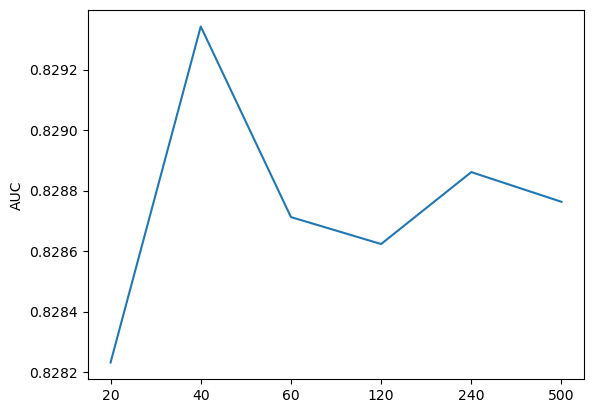

In [744]:
sns.lineplot (x=results_epo_val.columns, y=results_epo_val.loc['AUC'])

In [745]:
results_epo_train.loc[['AUC']]

,20,40,60,120,240,500
AUC,0.831554,0.835194,0.836453,0.842411,0.866163,0.917176


<AxesSubplot: ylabel='AUC'>

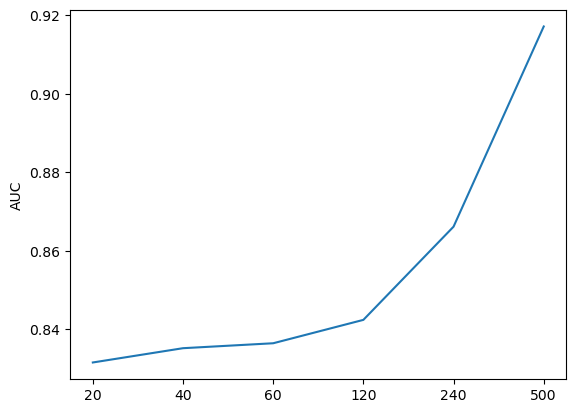

In [746]:
sns.lineplot (x=results_epo_train.columns, y=results_epo_train.loc['AUC'])

In [747]:
results_epo_test.loc[['AUC']]

,20,40,60,120,240,500
AUC,0.827198,0.82529,0.820351,0.796517,0.68567,0.640681


<AxesSubplot: ylabel='AUC'>

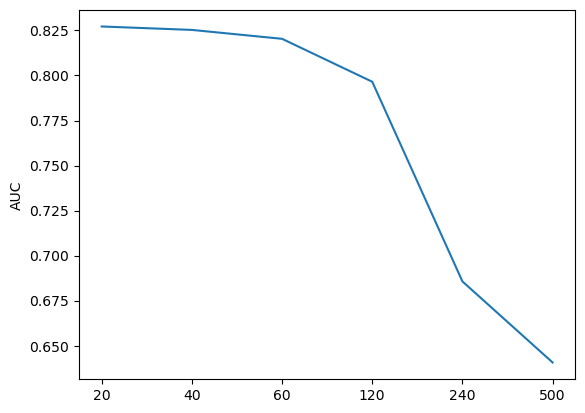

In [748]:
sns.lineplot (x=results_epo_test.columns, y=results_epo_test.loc['AUC'])

#### Обучим еще раз сеть с учетом новых данных и попробуем поднять результаты на тестовом наборе

In [749]:
input_ = tf.keras.layers.Input(shape=X_train.shape[1:])

hidden1 = tf.keras.layers.Dense(500, activation="relu")(input_)
hidden1B = tf.keras.layers.Dense(500, activation="relu")(input_)

hidden2 = tf.keras.layers.Dense(500, activation="relu")(hidden1)
hidden3 = tf.keras.layers.Dense(500, activation="relu")(hidden2)

concat = tf.keras.layers.concatenate([hidden1B, hidden3])

output = tf.keras.layers.Dense(1, activation='sigmoid')(concat)

model = tf.keras.models.Model(inputs=[input_], outputs=[output])

model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=['accuracy', AUC()])

history = model.fit(X_train, y_train, batch_size=4096,
                    epochs=20,
                    validation_data=(X_val, y_val))

model.evaluate(X_test, y_test)

Epoch 1/20
26/26 [==============================] - 1s 28ms/step - loss: 0.2600 - accuracy: 0.9287 - auc_147: 0.6885 - val_loss: 0.1950 - val_accuracy: 0.9358 - val_auc_147: 0.8141
Epoch 2/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1922 - accuracy: 0.9360 - auc_147: 0.8165 - val_loss: 0.1935 - val_accuracy: 0.9365 - val_auc_147: 0.8197
Epoch 3/20
26/26 [==============================] - 0s 11ms/step - loss: 0.1902 - accuracy: 0.9365 - auc_147: 0.8213 - val_loss: 0.1926 - val_accuracy: 0.9359 - val_auc_147: 0.8216
Epoch 4/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1901 - accuracy: 0.9366 - auc_147: 0.8226 - val_loss: 0.1915 - val_accuracy: 0.9361 - val_auc_147: 0.8240
Epoch 5/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1891 - accuracy: 0.9366 - auc_147: 0.8259 - val_loss: 0.1920 - val_accuracy: 0.9364 - val_auc_147: 0.8233
Epoch 6/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1887 - accuracy: 0.9

[0.1932373344898224, 0.9353733658790588, 0.8242558836936951]

#### Вывод: При применении параметров результат AUC На тестовой выборке увеличился и составил 0.8242558836936951

# Заключение:

Нейронные сети ведут себя несколько иначе, нежели классические методики обучения и результат не всегда хорошо прогнозируем и зависит от сложности сети.

In [660]:
pd.DataFrame(results.loc['AUC']).sort_values(by='AUC', ascending=False).head(10)

,AUC
Model3 (2H - 512-512) (Train),0.867879
Model5 (4H - 512-512-512-512) (Train),0.866738
Model6 Conv (Train),0.858849
Model2 (1H - 750) (Train),0.843700
Model4 (3H - 512-512-512) (Train),0.839489
Model1 (1H - 10) (Train),0.831246
Model6 Conv (Val),0.829162
Model4 (3H - 512-512-512) (Val),0.828206
Model2 (1H - 750) (Val),0.826140
Model1 (1H - 10) (Test),0.823097


Так мы можем видеть, что максимальный AUC на тренировочном сете мы можем видеть у Model3 (2H - 512-512), который составил 86.78, тогда как максимальный AUC на тестовом сете у модели  Model1 (1H - 10) и составил 82.3

В результате проведенного подбора параметров на приемере модели 6 мы видим.

1. По размерy Batch - Увеличение его размеров ведет к ухудшению результатов на тренировочном и валидационном сете, но улучшает результаты на тестовом наборе

2. По скорости обучение - Для показателей Train и Val оптимальнее выбирать значение в районе 0.01, тогда как для лучших результатов на тестовом наборе оптимальнее 0.001

3. Количество эпох - Улучшает результат на тестовом наборе (переобучение), но сильно ухудшает на тренировочном.